In [3]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('style.mcstyle')


## Plot test outputs

In [165]:
simpath = '/home/mattho/git/ltu-cmass/data/test/borg2lpt/L3000-N384/100'
rho = np.load(join(simpath, 'rho.npy'))
fvel = np.load(join(simpath, 'fvel.npy'))

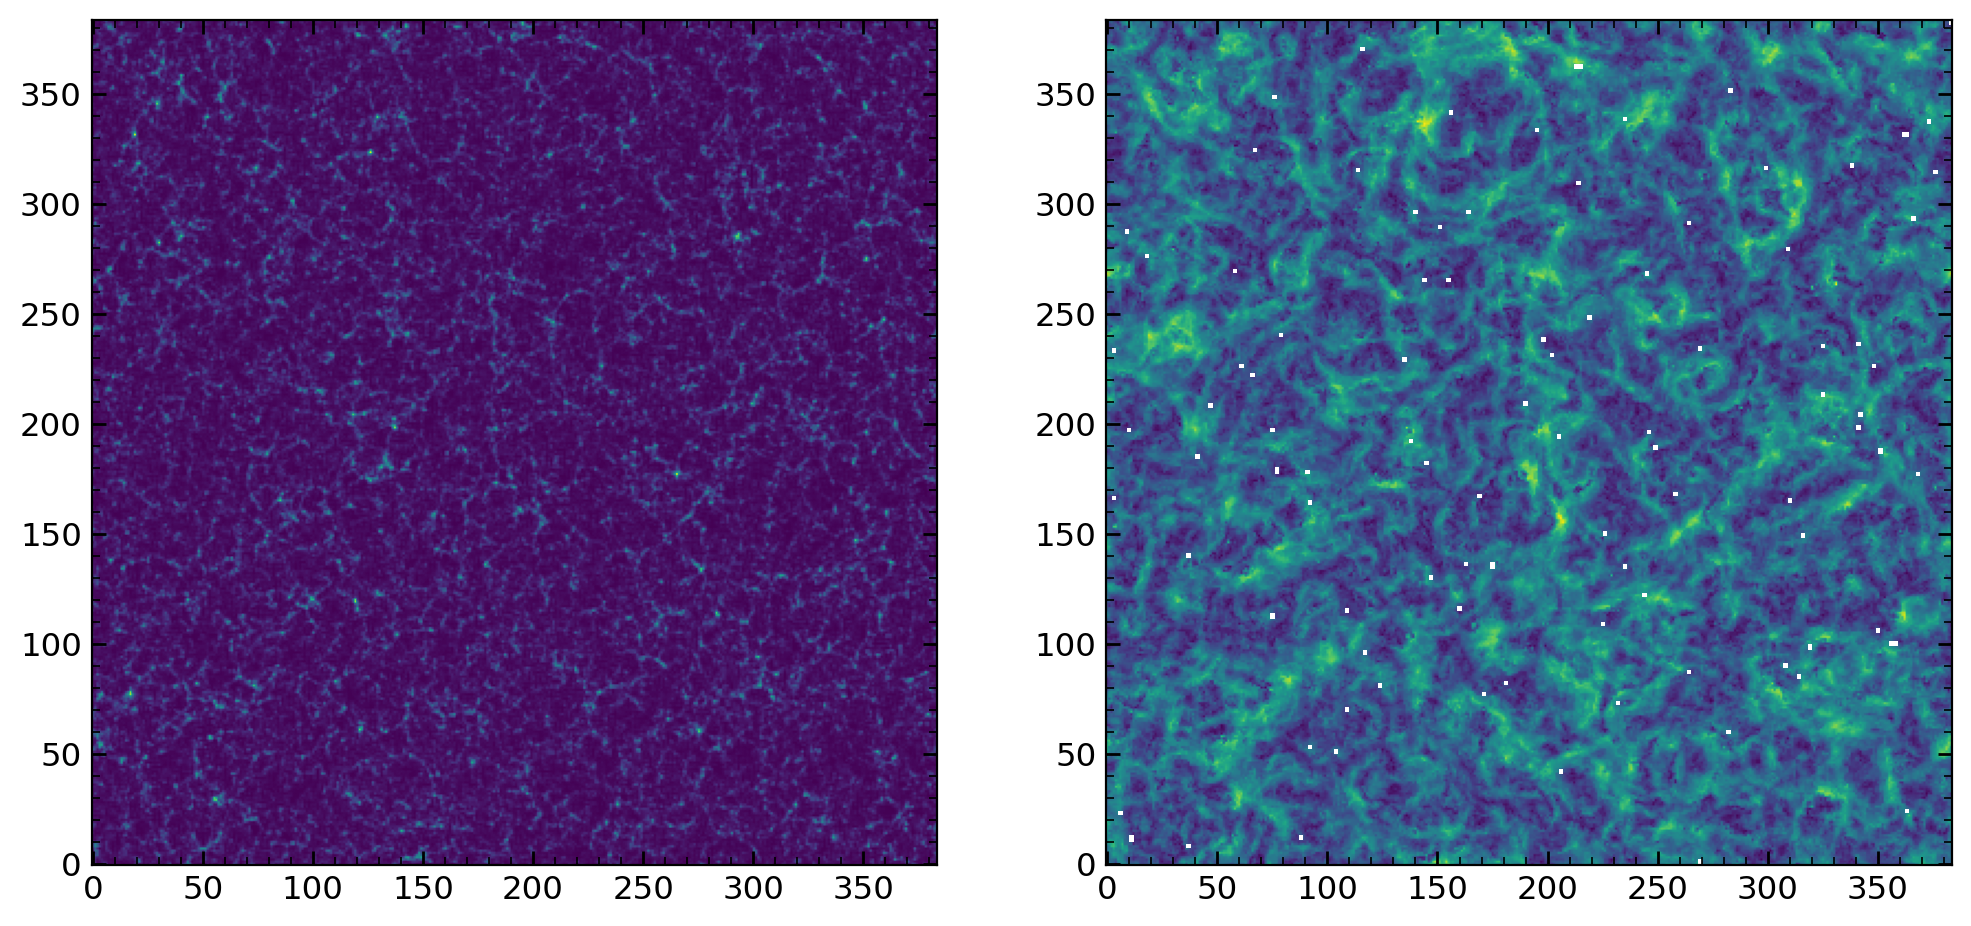

In [166]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(rho[:,100])
axs[1].imshow(np.linalg.norm(fvel[:,100], axis=-1))


In [167]:
hpos = np.load(join(simpath, 'halo_pos.npy'))
hvel = np.load(join(simpath, 'halo_vel.npy'))
gpos = np.load(join(simpath, 'hod', 'hod0_pos.npy'))
gvel = np.load(join(simpath, 'hod', 'hod0_vel.npy'))

hpos.min(axis=0), hpos.max(axis=0), gpos.min(axis=0), gpos.max(axis=0)
hvel.min(axis=0), hvel.max(axis=0), gvel.min(axis=0), gvel.max(axis=0)

(array([-2283.134 , -2276.306 , -2611.8406], dtype=float32),
 array([2246.246 , 2160.5583, 2283.7517], dtype=float32),
 array([-6367.5923, -6360.751 , -6418.812 ], dtype=float32),
 array([6474.6143, 6449.442 , 6561.7295], dtype=float32))

Text(0.5, 1.0, 'Galaxy positions, 52210822')

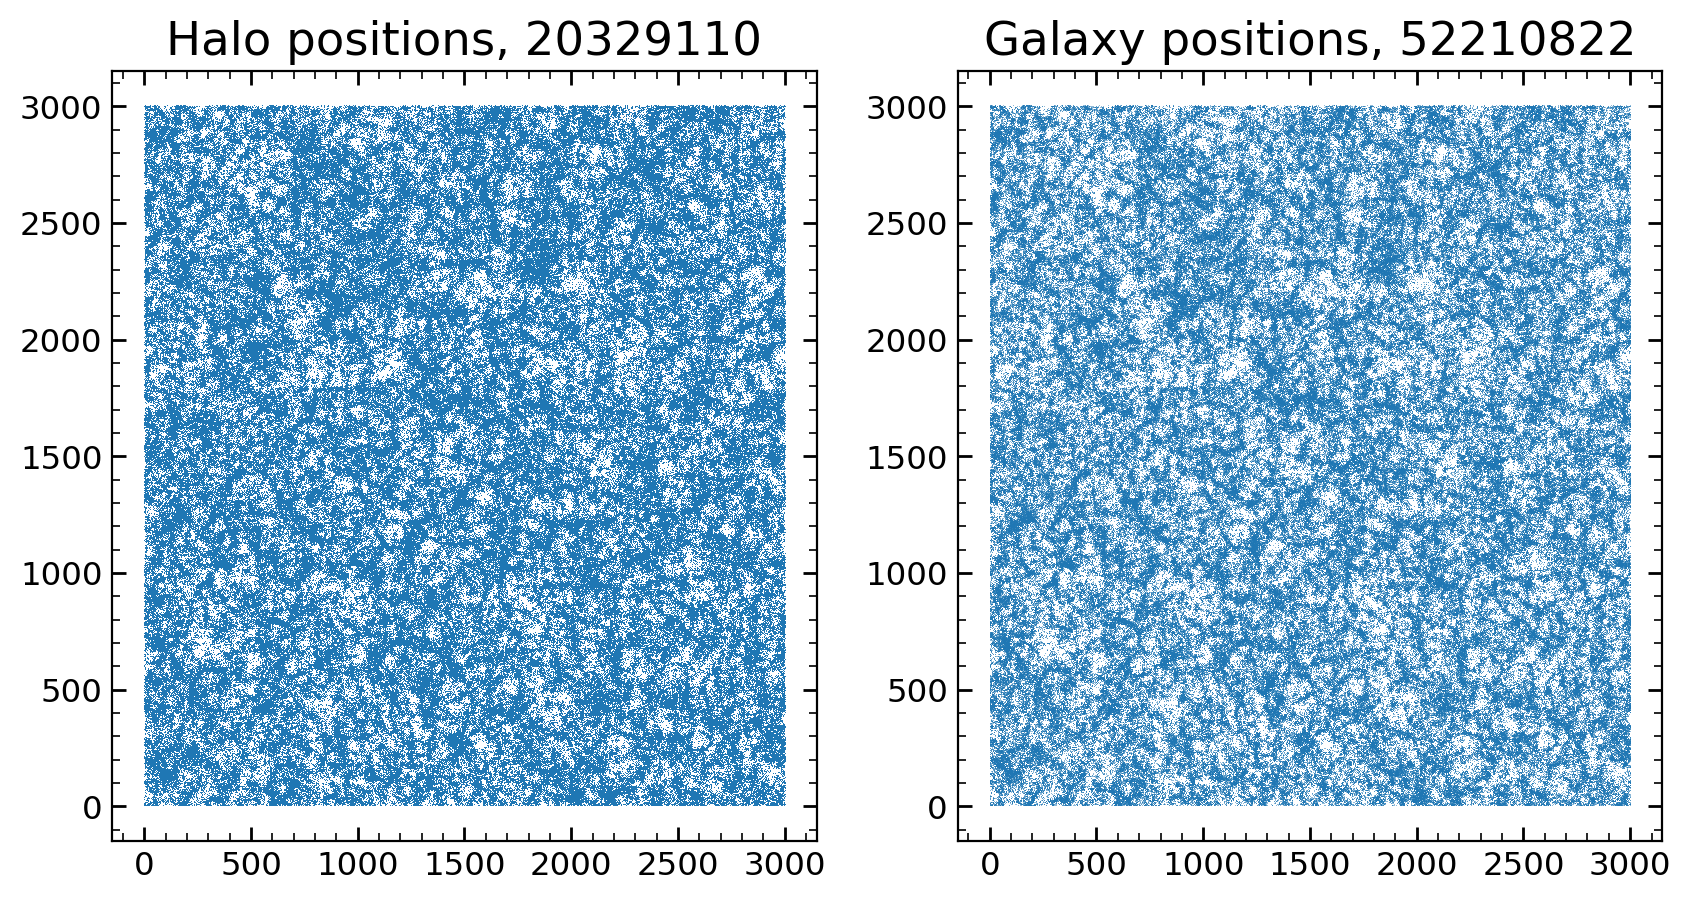

In [168]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))

mask = (hpos[:, 2] > 500) & (hpos[:, 2] < 600)
axs[0].plot(hpos[mask, 0], hpos[mask, 1], ',', ms=1, alpha=1)
axs[0].set_title(f'Halo positions, {len(hpos)}')

mask = (gpos[:, 2] > 500) & (gpos[:, 2] < 600)
axs[1].plot(gpos[mask, 0], gpos[mask, 1], ',', ms=1, alpha=0.5)
axs[1].set_title(f'Galaxy positions, {len(gpos)}')

In [195]:
grdz = np.load(join(simpath, 'obs', 'rdz0.npy'))

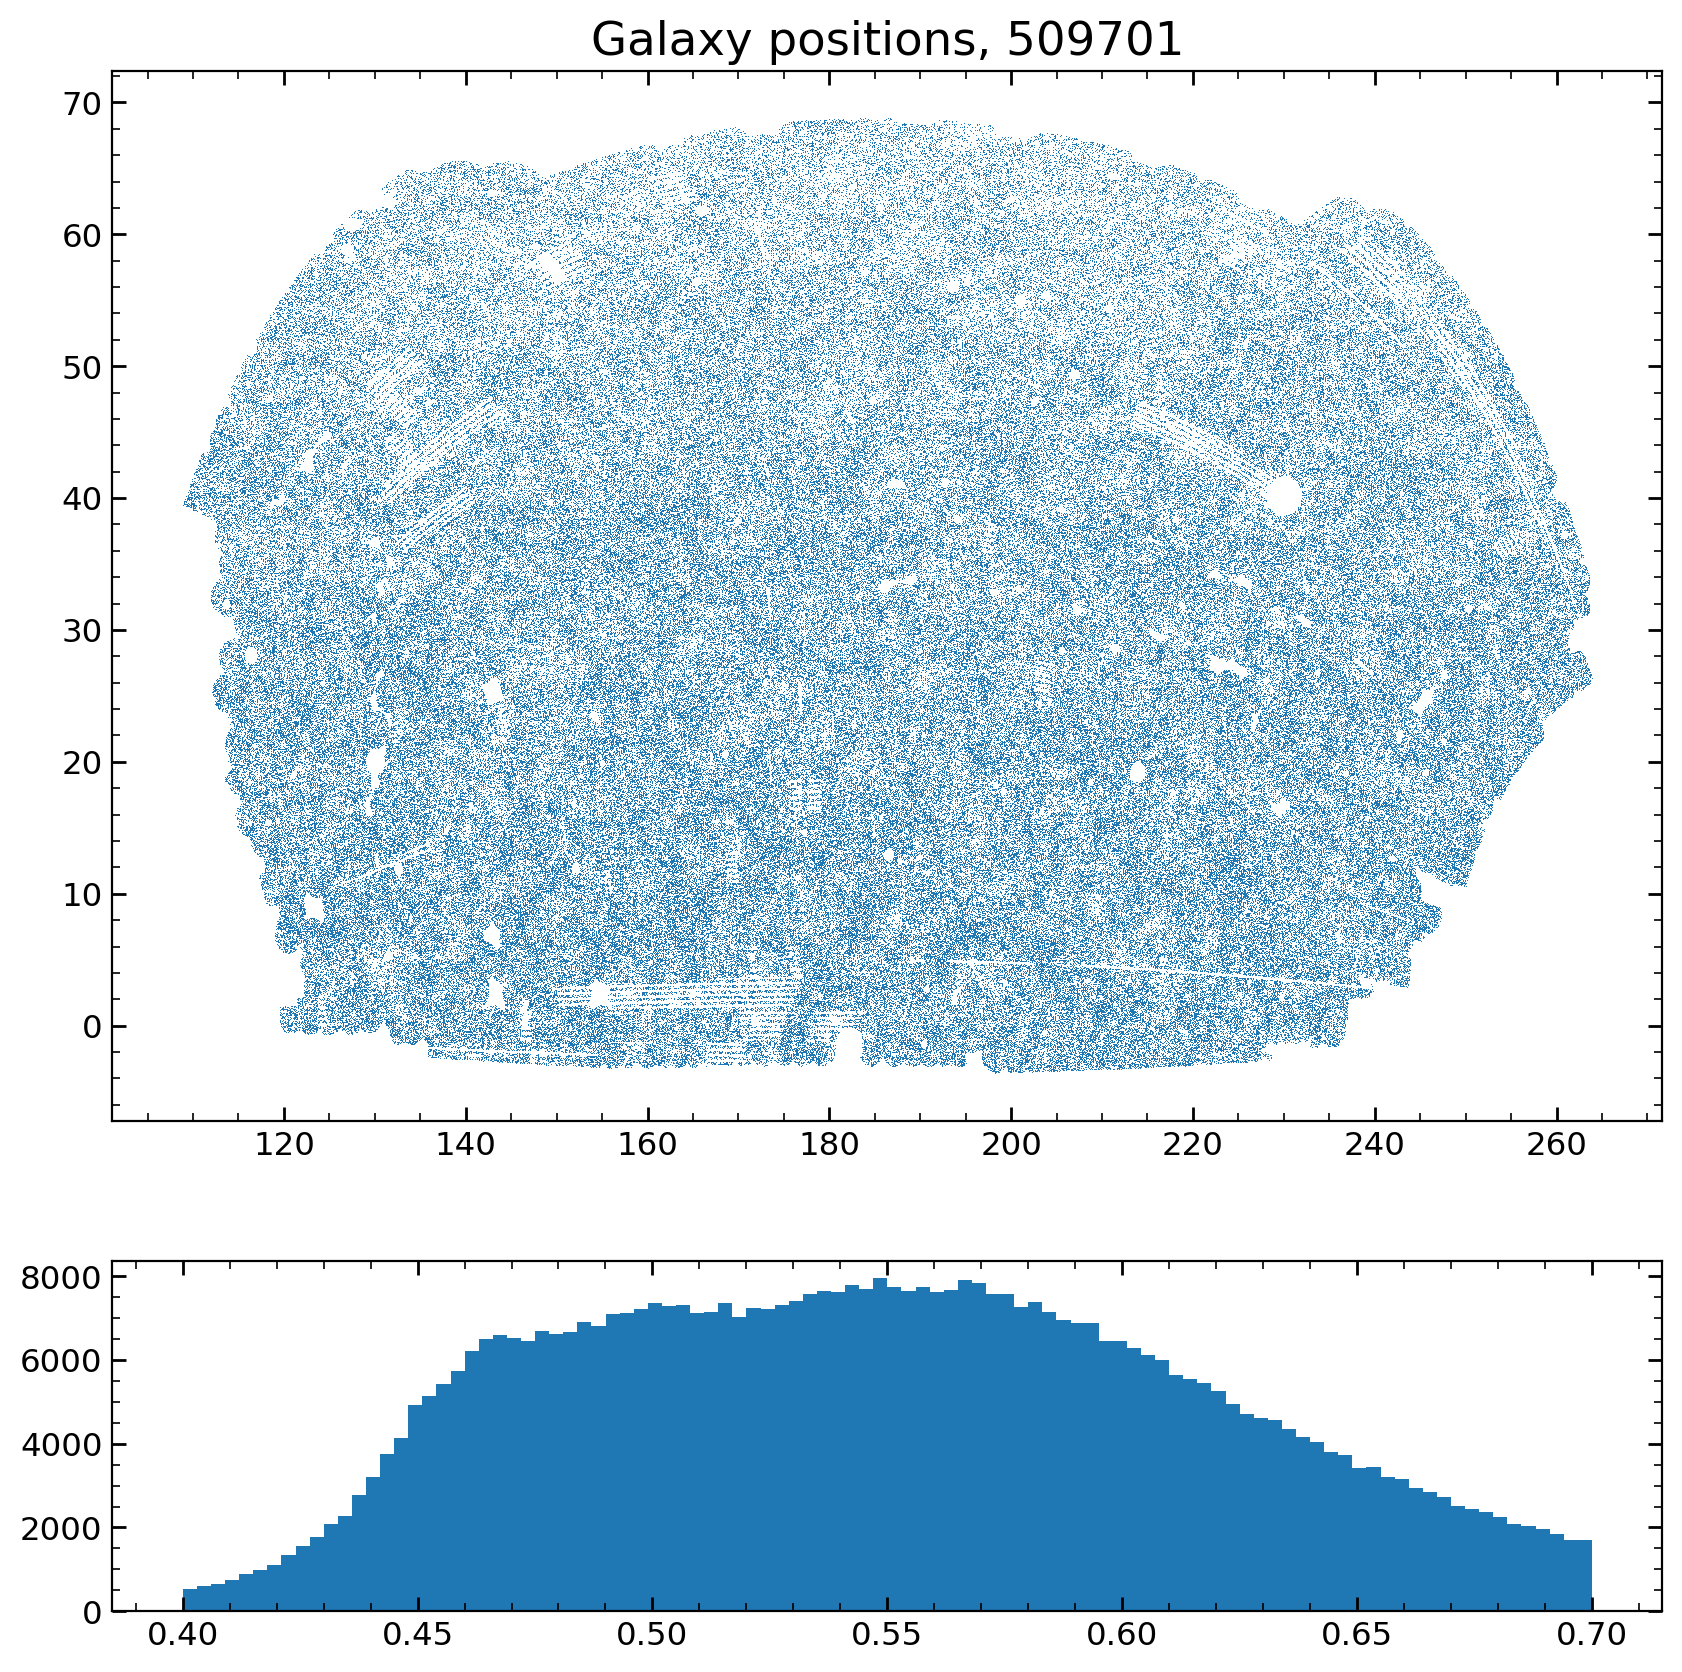

In [196]:
f, axs = plt.subplots(2,1, figsize=(10, 10),
                      gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(grdz[:, 0], grdz[:, 1], ',', ms=3, alpha=1)
axs[0].set_title(f'Galaxy positions, {len(grdz)}')
axs[1].hist(grdz[:, 2], bins=100);


## Explore observational sample

In [171]:
# load survey
import pandas as pd
from astropy.io import fits
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals
# load data
fname = '../data/obs/galaxy_DR12v5_CMASS_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)

In [172]:
from astropy.cosmology import Planck18
from cmass.survey.tools import sky_to_xyz

cosmo = Planck18
crdz = cmass[['RA', 'DEC', 'Z']].values

from cmass.survey.ngc_selection import apply_mask
crdz = apply_mask(crdz, wdir='../data')
cxyz = sky_to_xyz(crdz, cosmo)

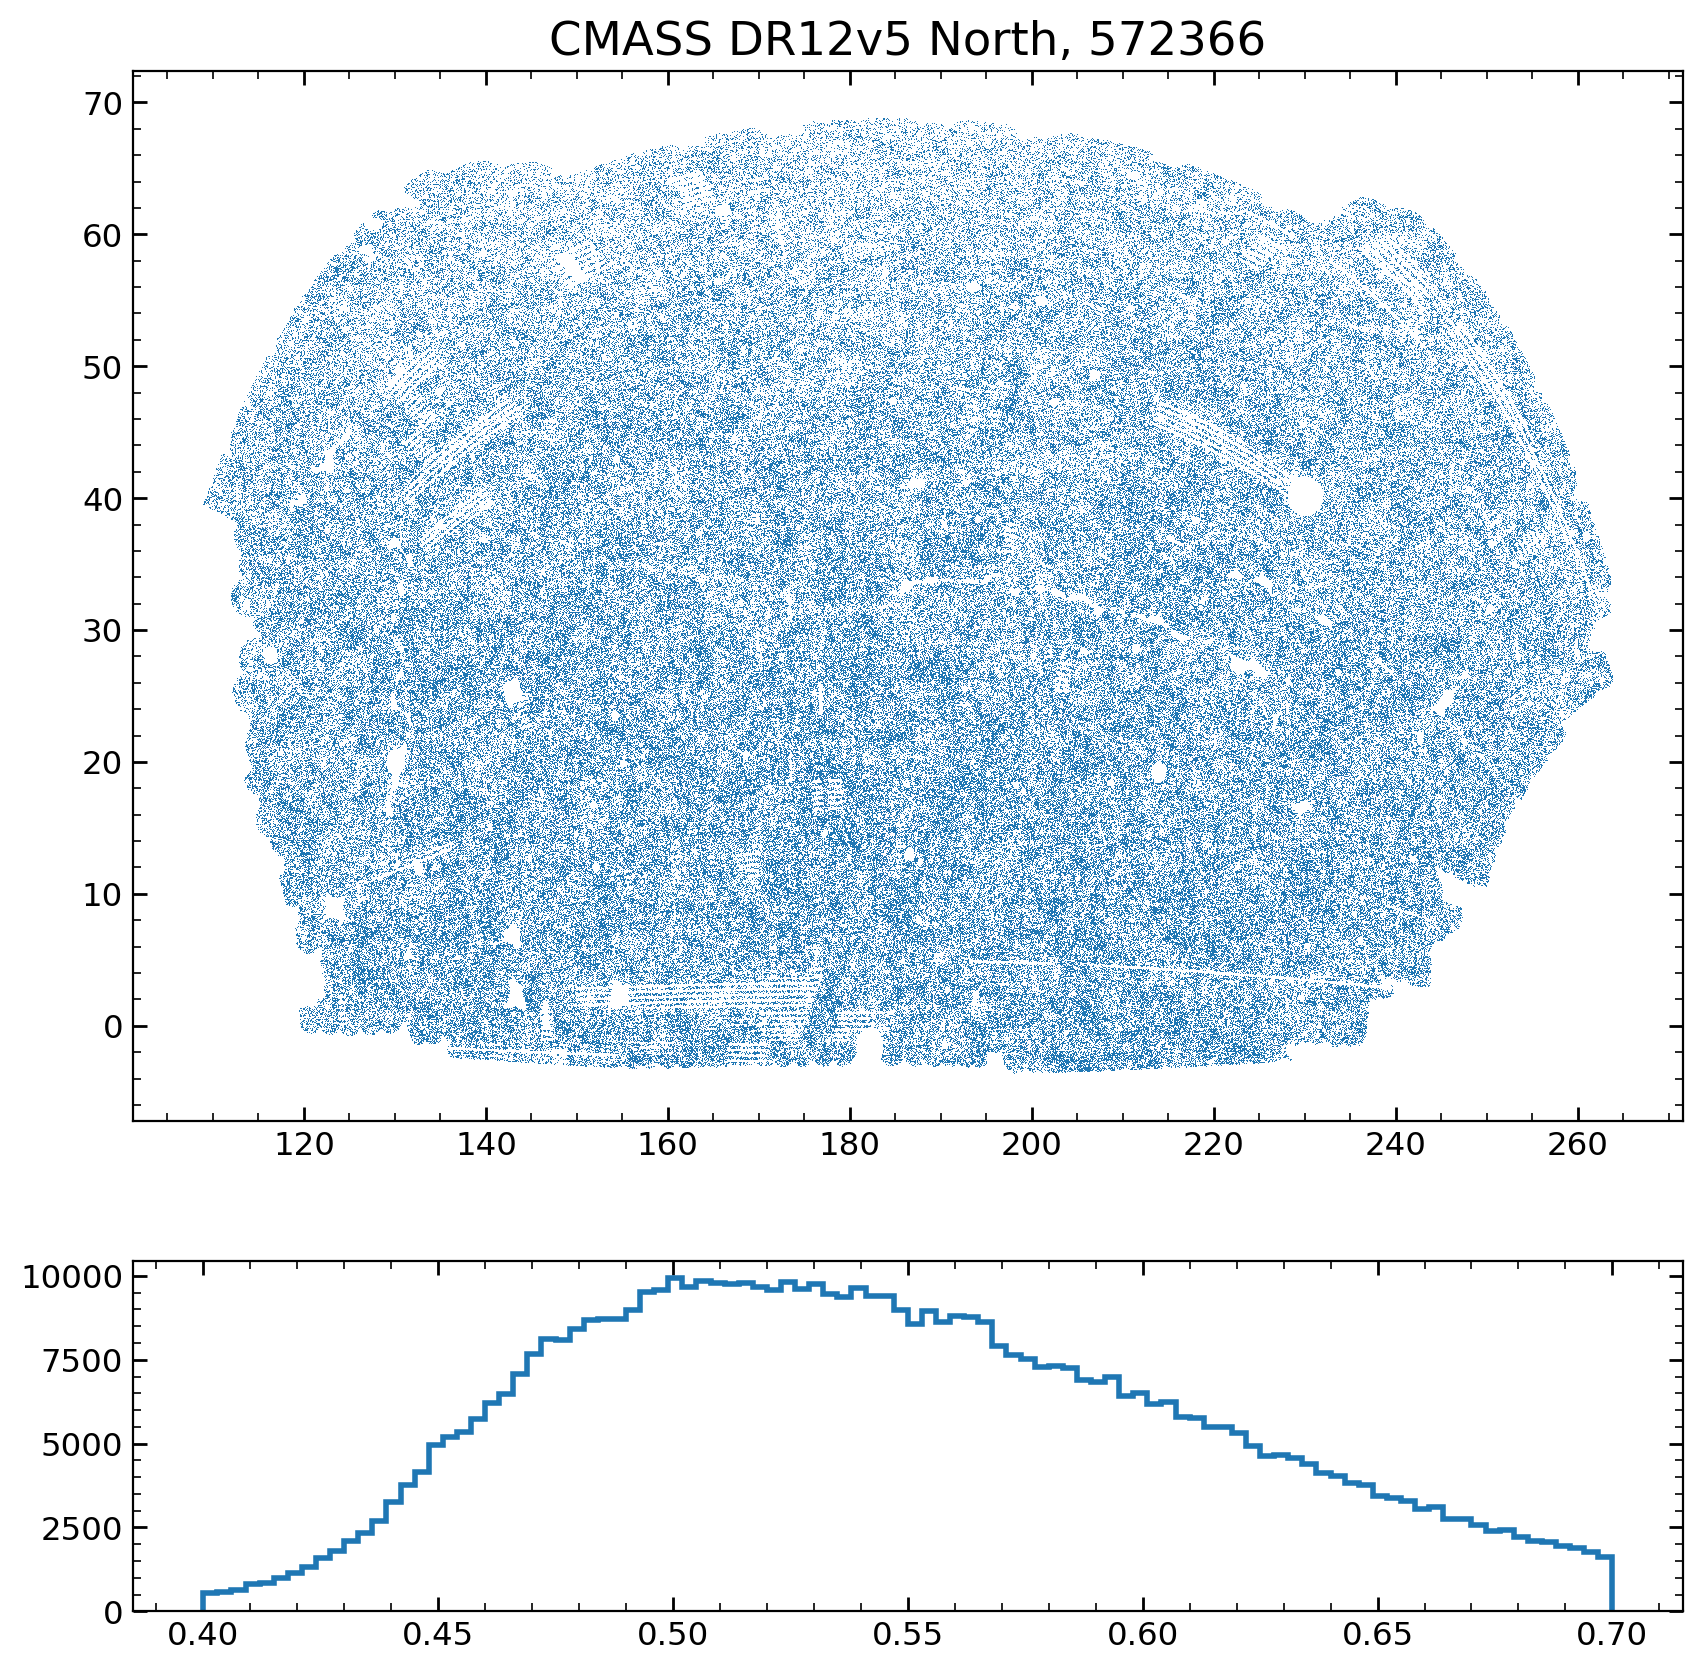

In [173]:
f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(crdz[:, 0], crdz[:, 1], ',', ms=1, alpha=1)
axs[0].set_title(f'CMASS DR12v5 North, {len(crdz)}')
axs[1].hist(crdz[:, 2], bins=100, histtype='step', lw=2);

In [126]:
min_rdz, max_rdz = crdz.min(axis=0), crdz.max(axis=0)
median_rdz = (min_rdz + max_rdz) / 2


In [183]:
from cmass.survey.tools import xyz_to_sky

# find middle ra, dec, z
mean_xyz = np.mean(cxyz, axis=0)
med_rdz = xyz_to_sky(mean_xyz, cosmo=cosmo)[0]
print('middle_rdz:', tuple(med_rdz))
med_xyz = sky_to_xyz(med_rdz, cosmo)

from cmass.survey.tools import rotate_to_z

rot, rot_inv = rotate_to_z(med_xyz, cosmo)

middle_rdz: (184.83975076425324, 34.03863916513374, 0.4194598771198273)


In [184]:
# move to (0, 0, 0) and rotate to z-axis
zcxyz = cxyz - med_xyz
zcxyz = rot.apply(zcxyz)

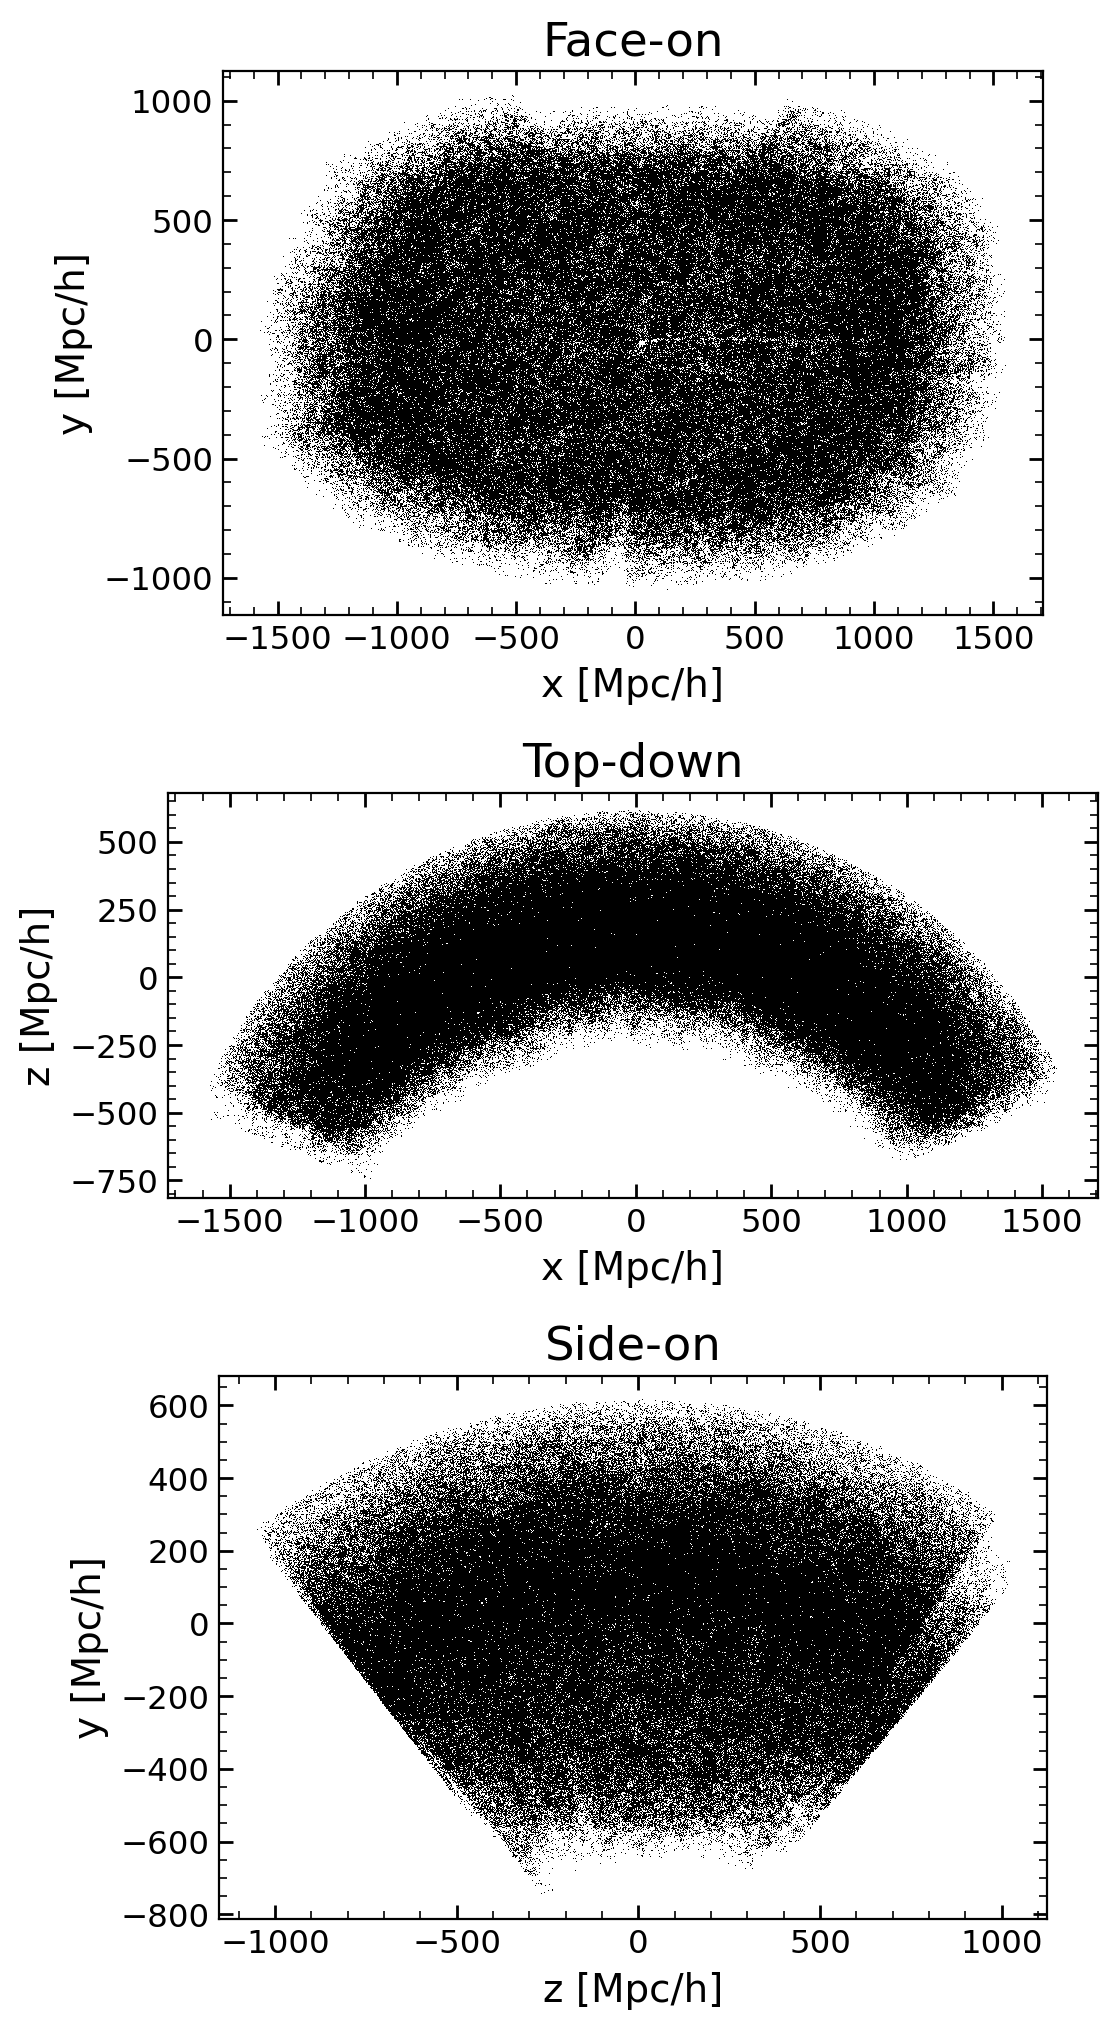

In [185]:
f, axs = plt.subplots(3, 1, figsize=(6, 12))

ax = axs[0]
ax.plot(zcxyz[:,0], zcxyz[:,1], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', title='Face-on')

ax = axs[1]
ax.plot(zcxyz[:,0], zcxyz[:,2], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='z [Mpc/h]', title='Top-down')

ax = axs[2]
ax.plot(zcxyz[:,1], zcxyz[:,2], 'k,', alpha=1)
ax.set_aspect('equal')
ax.set(xlabel='z [Mpc/h]', ylabel='y [Mpc/h]', title='Side-on');

In [186]:
# get comoving ranges (check that we are in the center)
ranges = np.stack([np.min(zcxyz, axis=0), np.max(zcxyz, axis=0)])
mids = np.mean(ranges, axis=0)
vol = np.prod(ranges[1] - ranges[0])
print(f'Volume=({vol**(1/3):.4f} Mpc/h)^3')
for i in range(3):
    print(f'{i}: {np.diff(ranges[:,i])[0]:.3f} Mpc/h')

Volume=(2063.7699 Mpc/h)^3
0: 3122.173 Mpc/h
1: 2070.771 Mpc/h
2: 1359.549 Mpc/h


In [187]:
# check remap geometry

import cuboid_remap as cremap

# Desired geometry
geometry = np.diff(ranges, axis=0)# Mpc/h

# Preset geometry
u1 = [1,1,0]
u2 = [0,0,1]
u3 = [1,0,0]
target_geometry = np.array(cremap.remap_Lbox(u1, u2, u3))*3000  # Mpc/h

print(f"Desired geometry = {geometry}")
print(f"target_geometry = {target_geometry}")

# u1, u2, u3 = latvecs[key][0]
print(f"u1 = {u1}")
print(f"u2 = {u2}")
print(f"u3 = {u3}")


Desired geometry = [[3122.17296256 2070.77124455 1359.54865409]]
target_geometry = [4242.64068712 3000.         2121.32034356]
u1 = [1, 1, 0]
u2 = [0, 0, 1]
u3 = [1, 0, 0]


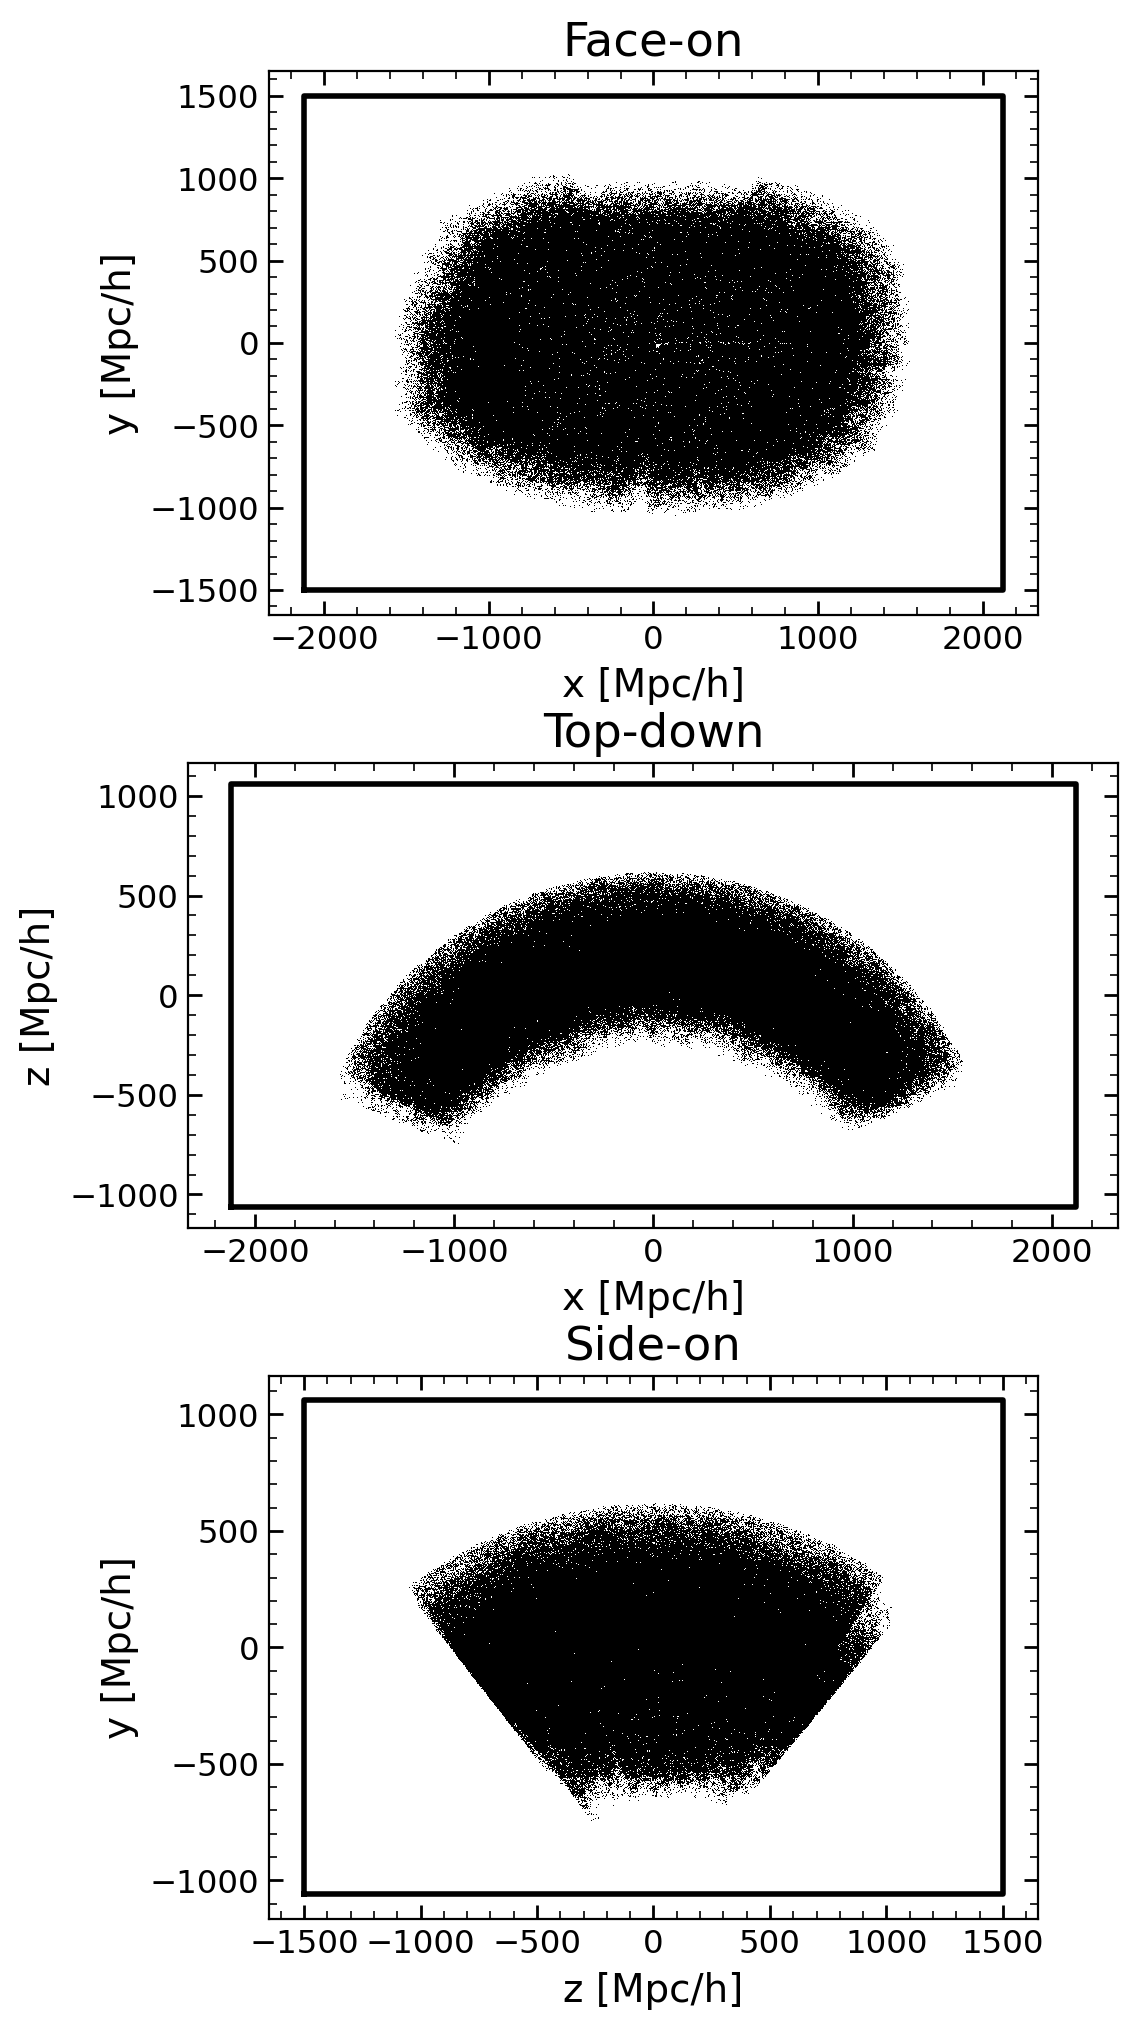

In [188]:
def plot_rectangle(x, y, Lx, Ly, ax, c='k'):
    ax.plot([x-Lx/2, x+Lx/2, x+Lx/2, x-Lx/2, x-Lx/2], 
            [y-Ly/2, y-Ly/2, y+Ly/2, y+Ly/2, y-Ly/2], 
            c=c)

f, axs = plt.subplots(3, 1, figsize=(6, 12))

ax = axs[0]
ax.plot(zcxyz[:,0], zcxyz[:,1], 'k,', alpha=1)
plot_rectangle(0, 0, target_geometry[0], target_geometry[1], ax)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', title='Face-on')

ax = axs[1]
ax.plot(zcxyz[:,0], zcxyz[:,2], 'k,', alpha=1)
plot_rectangle(0, 0, target_geometry[0], target_geometry[2], ax)
ax.set_aspect('equal')
ax.set(xlabel='x [Mpc/h]', ylabel='z [Mpc/h]', title='Top-down')

ax = axs[2]
ax.plot(zcxyz[:,1], zcxyz[:,2], 'k,', alpha=1)
plot_rectangle(0, 0, target_geometry[1], target_geometry[2], ax)
ax.set_aspect('equal')
ax.set(xlabel='z [Mpc/h]', ylabel='y [Mpc/h]', title='Side-on');

In [181]:
import jax
C = cremap.Cuboid(u1=u1, u2=u2, u3=u3)
Lbox = 3000  # Mpc/h

# transform to cuboid
transform = jax.vmap(C.Transform, in_axes=0)
gposT = transform(gpos/Lbox)*Lbox

# move to origin
gposT -= np.mean(gposT, axis=0)

# rotate
gxyz = rot_inv.apply(gposT)

# move back
gxyz += med_xyz

# rotate velocities
gvelT = C.TransformVelocity(gvel)
gvel = rot_inv.apply(gvelT.T)

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


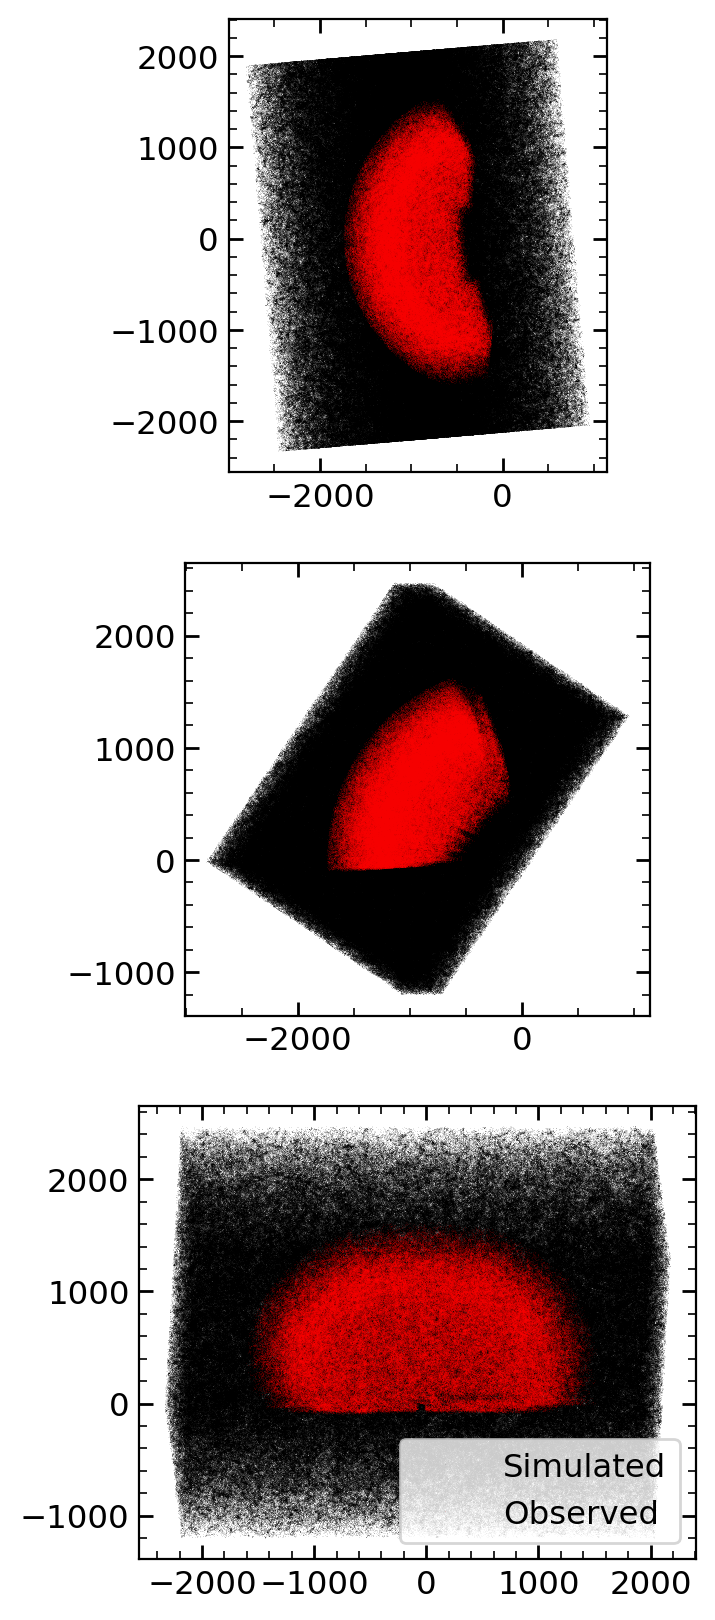

In [182]:
# plot simulated galaxies in the survey footprint

f, axs = plt.subplots(3, 1, figsize=(10, 10))

ax = axs[0]
mask = np.random.rand(len(gxyz)) < 0.1
ax.plot(gxyz[mask, 0], gxyz[mask,1], 'k,', alpha=0.1)
ax.plot(cxyz[:, 0], cxyz[:,1], 'r,', alpha=0.1)
ax.set_aspect('equal')

ax = axs[1]
ax.plot(gxyz[mask, 0], gxyz[mask,2], 'k,', alpha=0.1)
ax.plot(cxyz[:, 0], cxyz[:,2], 'r,', alpha=0.1)
ax.set_aspect('equal')

ax = axs[2]
ax.plot(gxyz[mask, 1], gxyz[mask,2], 'k,', alpha=0.1, label='Simulated')
ax.plot(cxyz[:, 1], cxyz[:,2], 'r,', alpha=0.1, label='Observed')
ax.set_aspect('equal')
ax.legend()

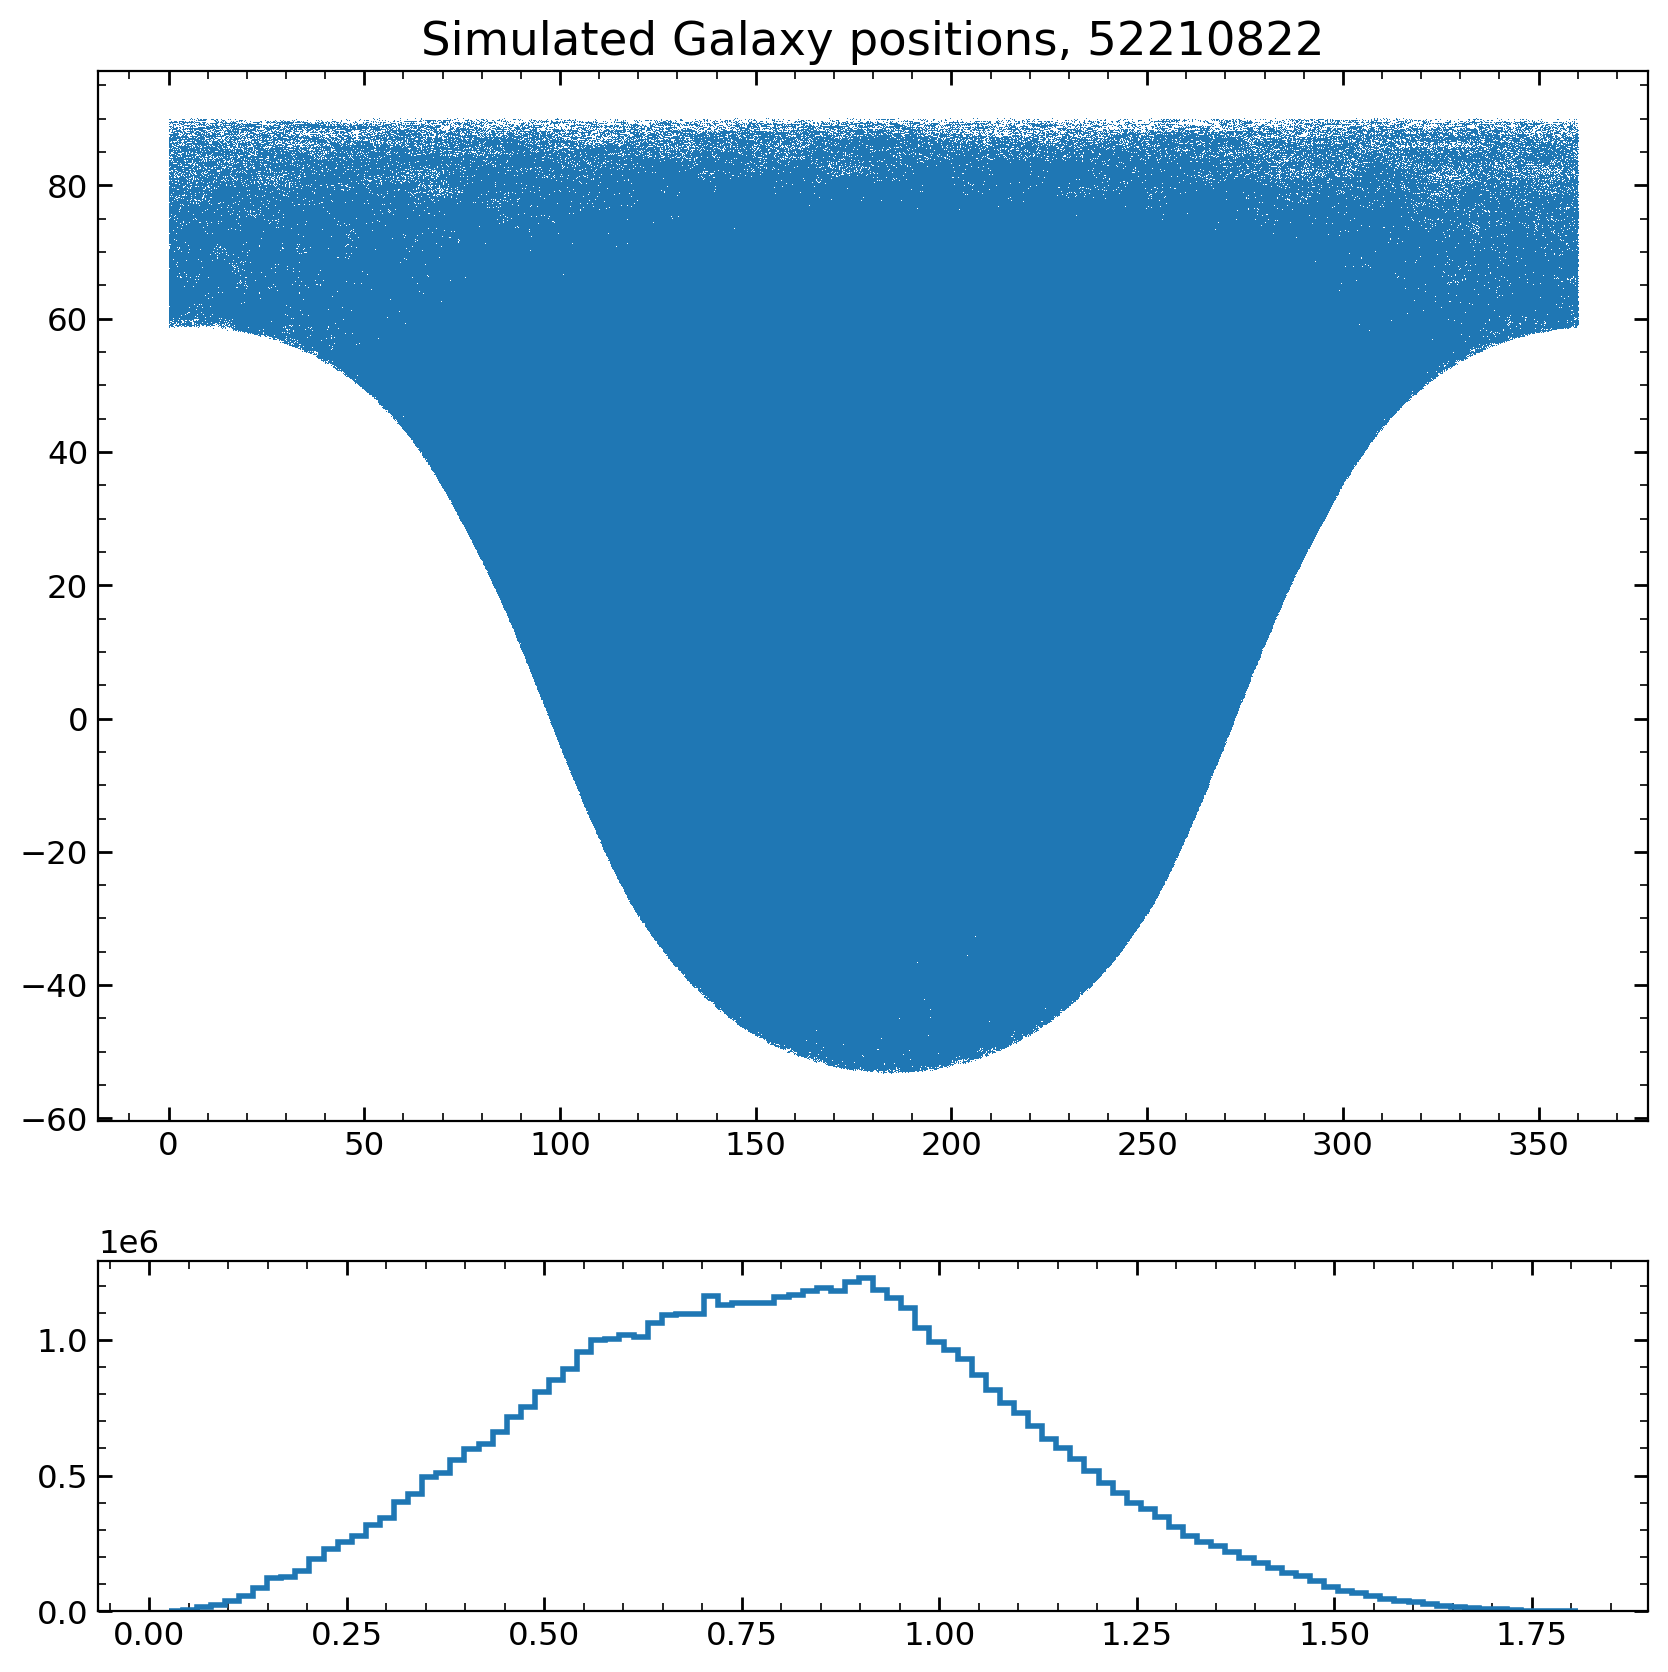

In [135]:
grdzs = xyz_to_sky(gxyz, gvel, cosmo)

f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(grdzs[:, 0], grdzs[:, 1], ',', ms=3, alpha=1)
axs[0].set_title(f'Simulated Galaxy positions, {len(grdzs)}')
axs[1].hist(grdzs[:, 2], bins=100, histtype='step', lw=2);

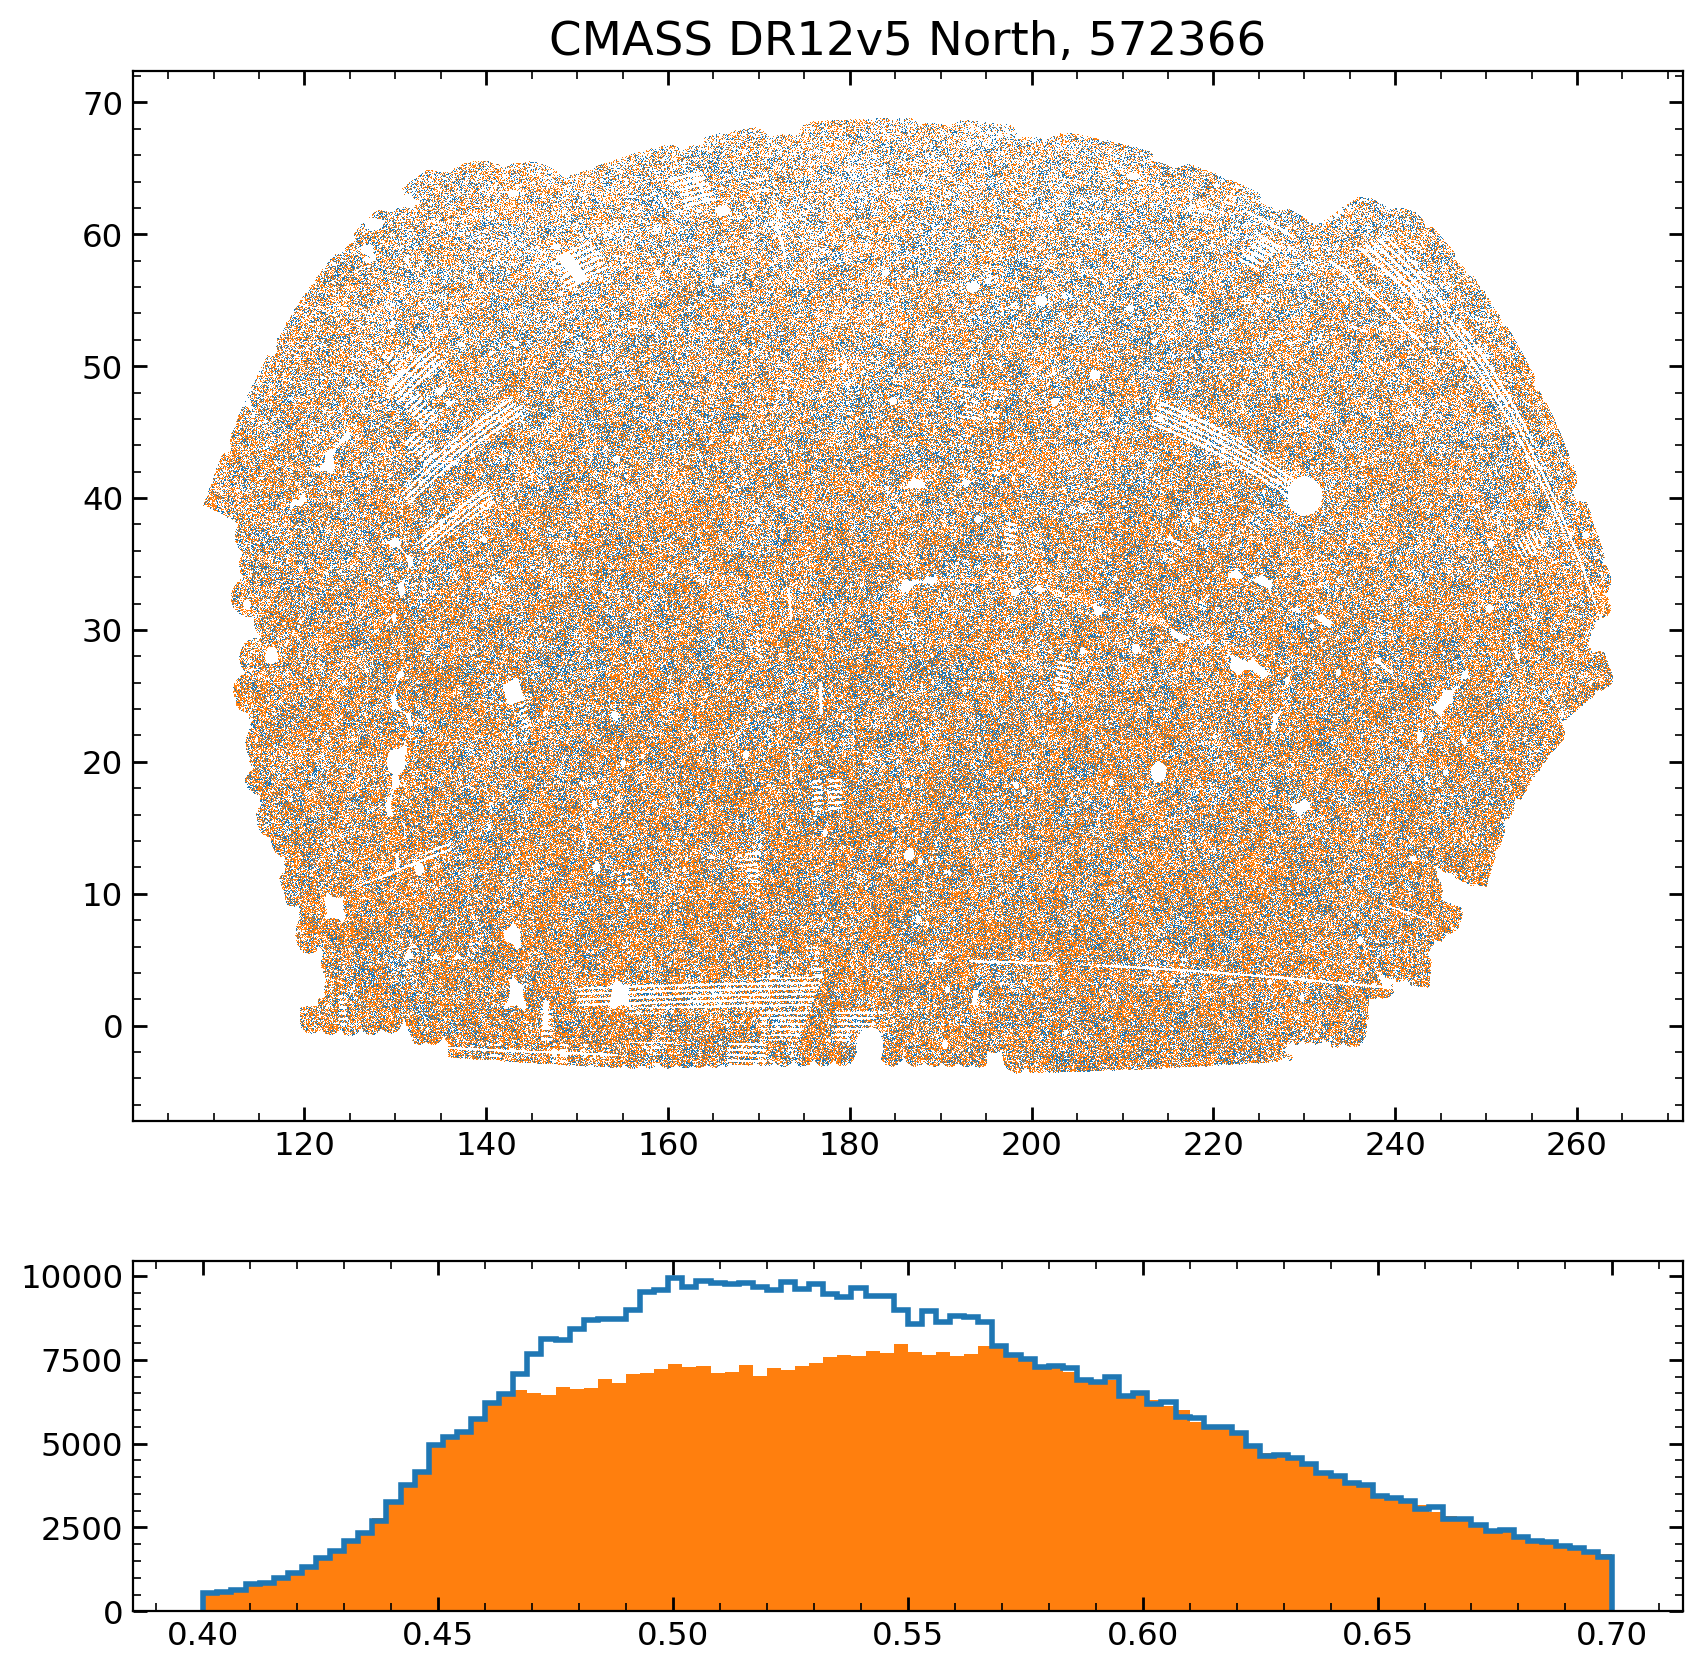

In [197]:
f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(crdz[:, 0], crdz[:, 1], ',', ms=1, alpha=1)
axs[0].set_title(f'CMASS DR12v5 North, {len(crdz)}')
axs[1].hist(crdz[:, 2], bins=100, histtype='step', lw=2)


axs[0].plot(grdz[:, 0], grdz[:, 1], ',', ms=3, alpha=1)
axs[1].hist(grdz[:, 2], bins=100);

In [193]:
wdir = '../data'
n_z = np.load(
    join(wdir, 'obs', 'n-z_DR12v5_CMASS_North.npy'),
    allow_pickle=True).item()
be, hobs = n_z['be'], n_z['h']

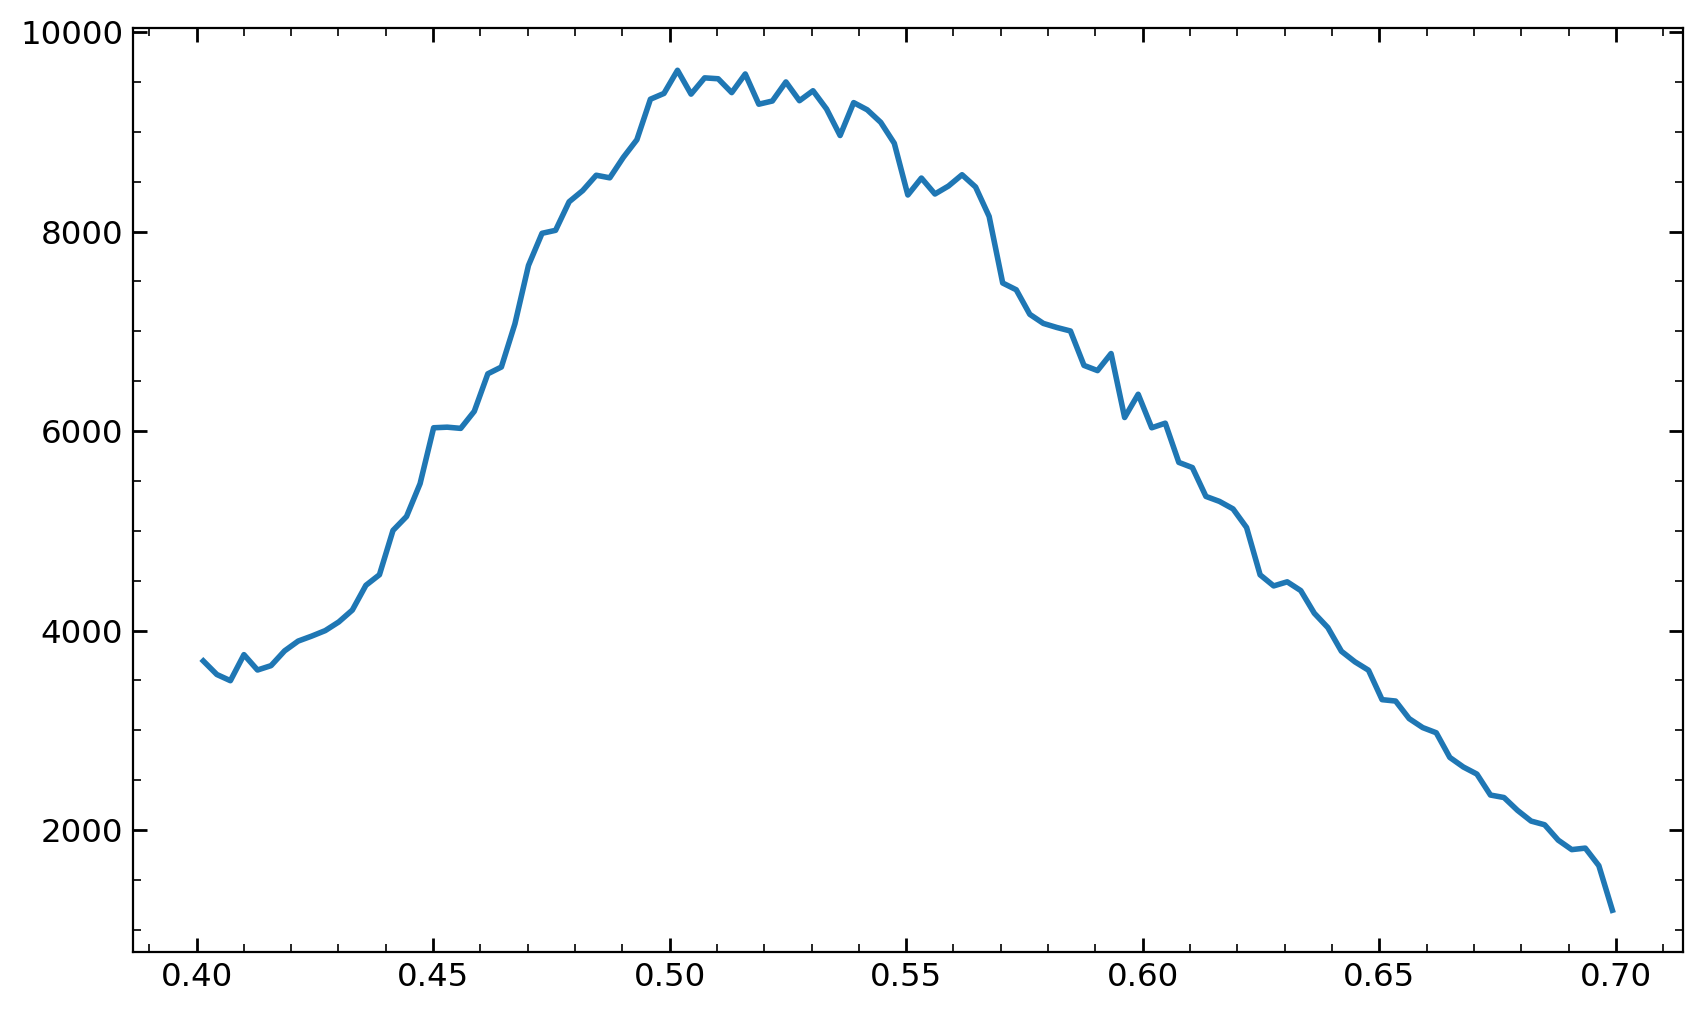

In [194]:
bc = (be[1:] + be[:-1]) / 2
plt.plot(bc, hobs, label='observed')

## Test in-code

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18
cosmo = Planck18

from cmass.survey.ngc_selection import (
    random_rotate_translate, remap, move_to_footprint,
    xyz_to_sky, sky_to_xyz, apply_mask, BOSS_angular
)

In [155]:
L = 3000
N = 64
perturb = L/N*0.5

gpos = np.linspace(0, L, N+1)[:-1]
gpos += L/(2*N)
gpos = [gpos]*3
gpos = np.stack(np.meshgrid(*gpos), axis=-1).reshape(-1, 3)
gpos = np.repeat(gpos, 2, axis=0)
gpos += np.random.rand(*gpos.shape)*perturb - perturb/2
gpos %= L

gvel = np.random.randn(*gpos.shape)

In [156]:
gpos2, gvel2 = random_rotate_translate(
    gpos, L=L, vel=gvel, seed=4
)
gpos, gvel = gpos2, gvel2

In [157]:
u1 = [1,1,0]
u2 = [0,0,1]
u3 = [1,0,1]

gpos2, gvel2 = remap(
    gpos, gvel, L, 
    u1, u2, u3
)
gpos, gvel = gpos2, gvel2
# np.isclose(np.linalg.norm(gvel, axis=-1), np.linalg.norm(gvel2, axis=-1)).all()

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


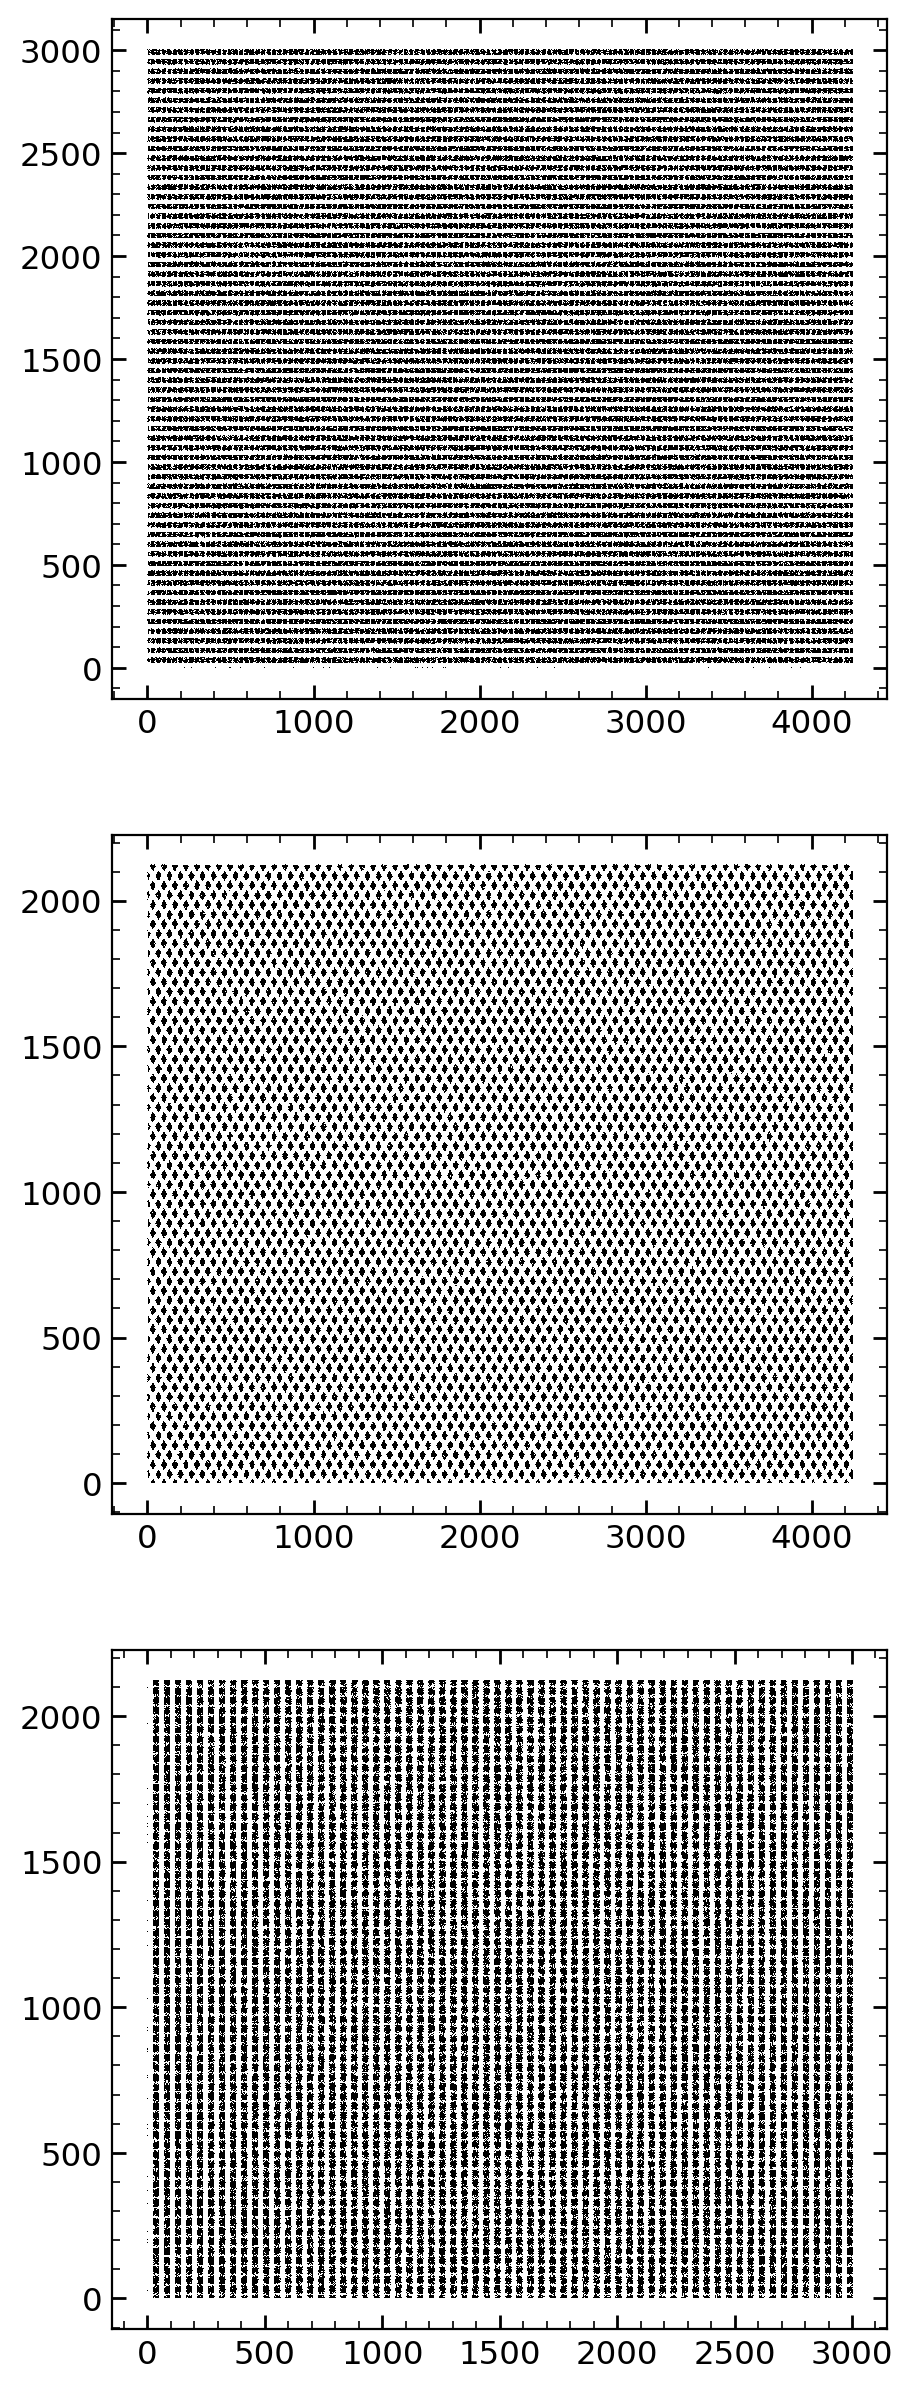

In [158]:
f, axs = plt.subplots(3, 1, figsize=(5, 15))

ax = axs[0]
ax.plot(gpos[:, 0], gpos[:, 1], 'k,', alpha=1)

ax = axs[1]
ax.plot(gpos[:, 0], gpos[:, 2], 'k,', alpha=1)

ax = axs[2]
ax.plot(gpos[:, 1], gpos[:, 2], 'k,', alpha=1)

In [159]:
median_rdz = np.median(crdz, axis=0)
med_rdz

array([184.8284631 ,  34.04022511,   0.41945907])

In [160]:
gpos2, gvel2 = move_to_footprint(
    gpos, gvel, med_rdz,
    cosmo, L
)
gpos, gvel = gpos2, gvel2

In [161]:
rdz = xyz_to_sky(gpos, gvel, cosmo)
xyz = sky_to_xyz(rdz, cosmo)

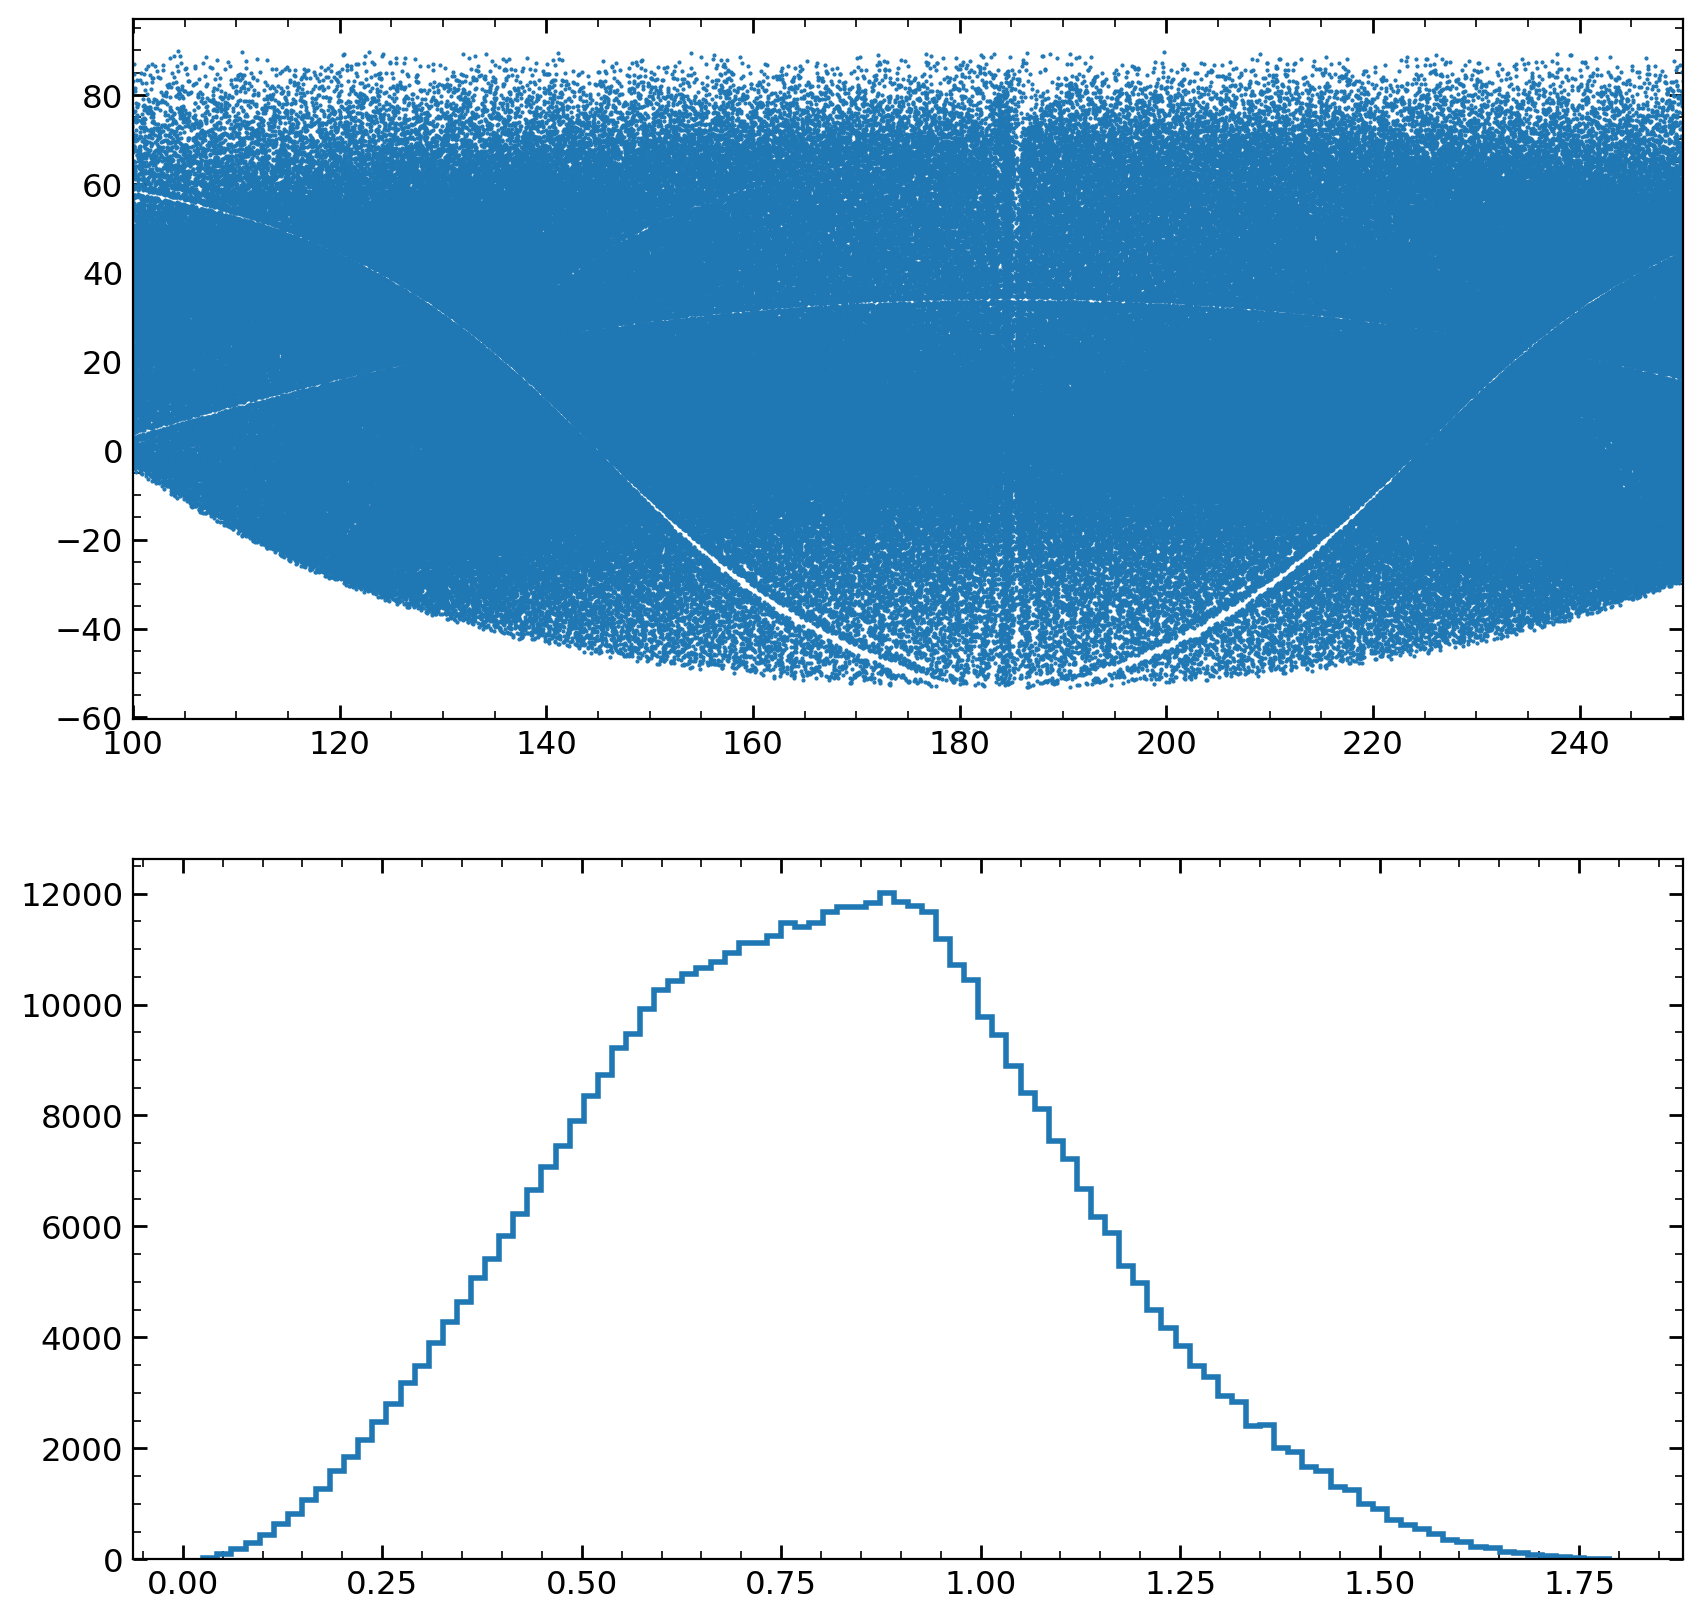

In [162]:
f, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(rdz[:, 0], rdz[:, 1], '.', ms=1, alpha=1)
axs[0].set_xlim(100,250)
axs[1].hist(rdz[:, 2], bins=100, histtype='step', lw=2);

In [163]:
wdir = '/home/mattho/git/ltu-cmass/data'
inpoly = BOSS_angular(*rdz[:, :-1].T, wdir=wdir)
rdz = rdz[inpoly]

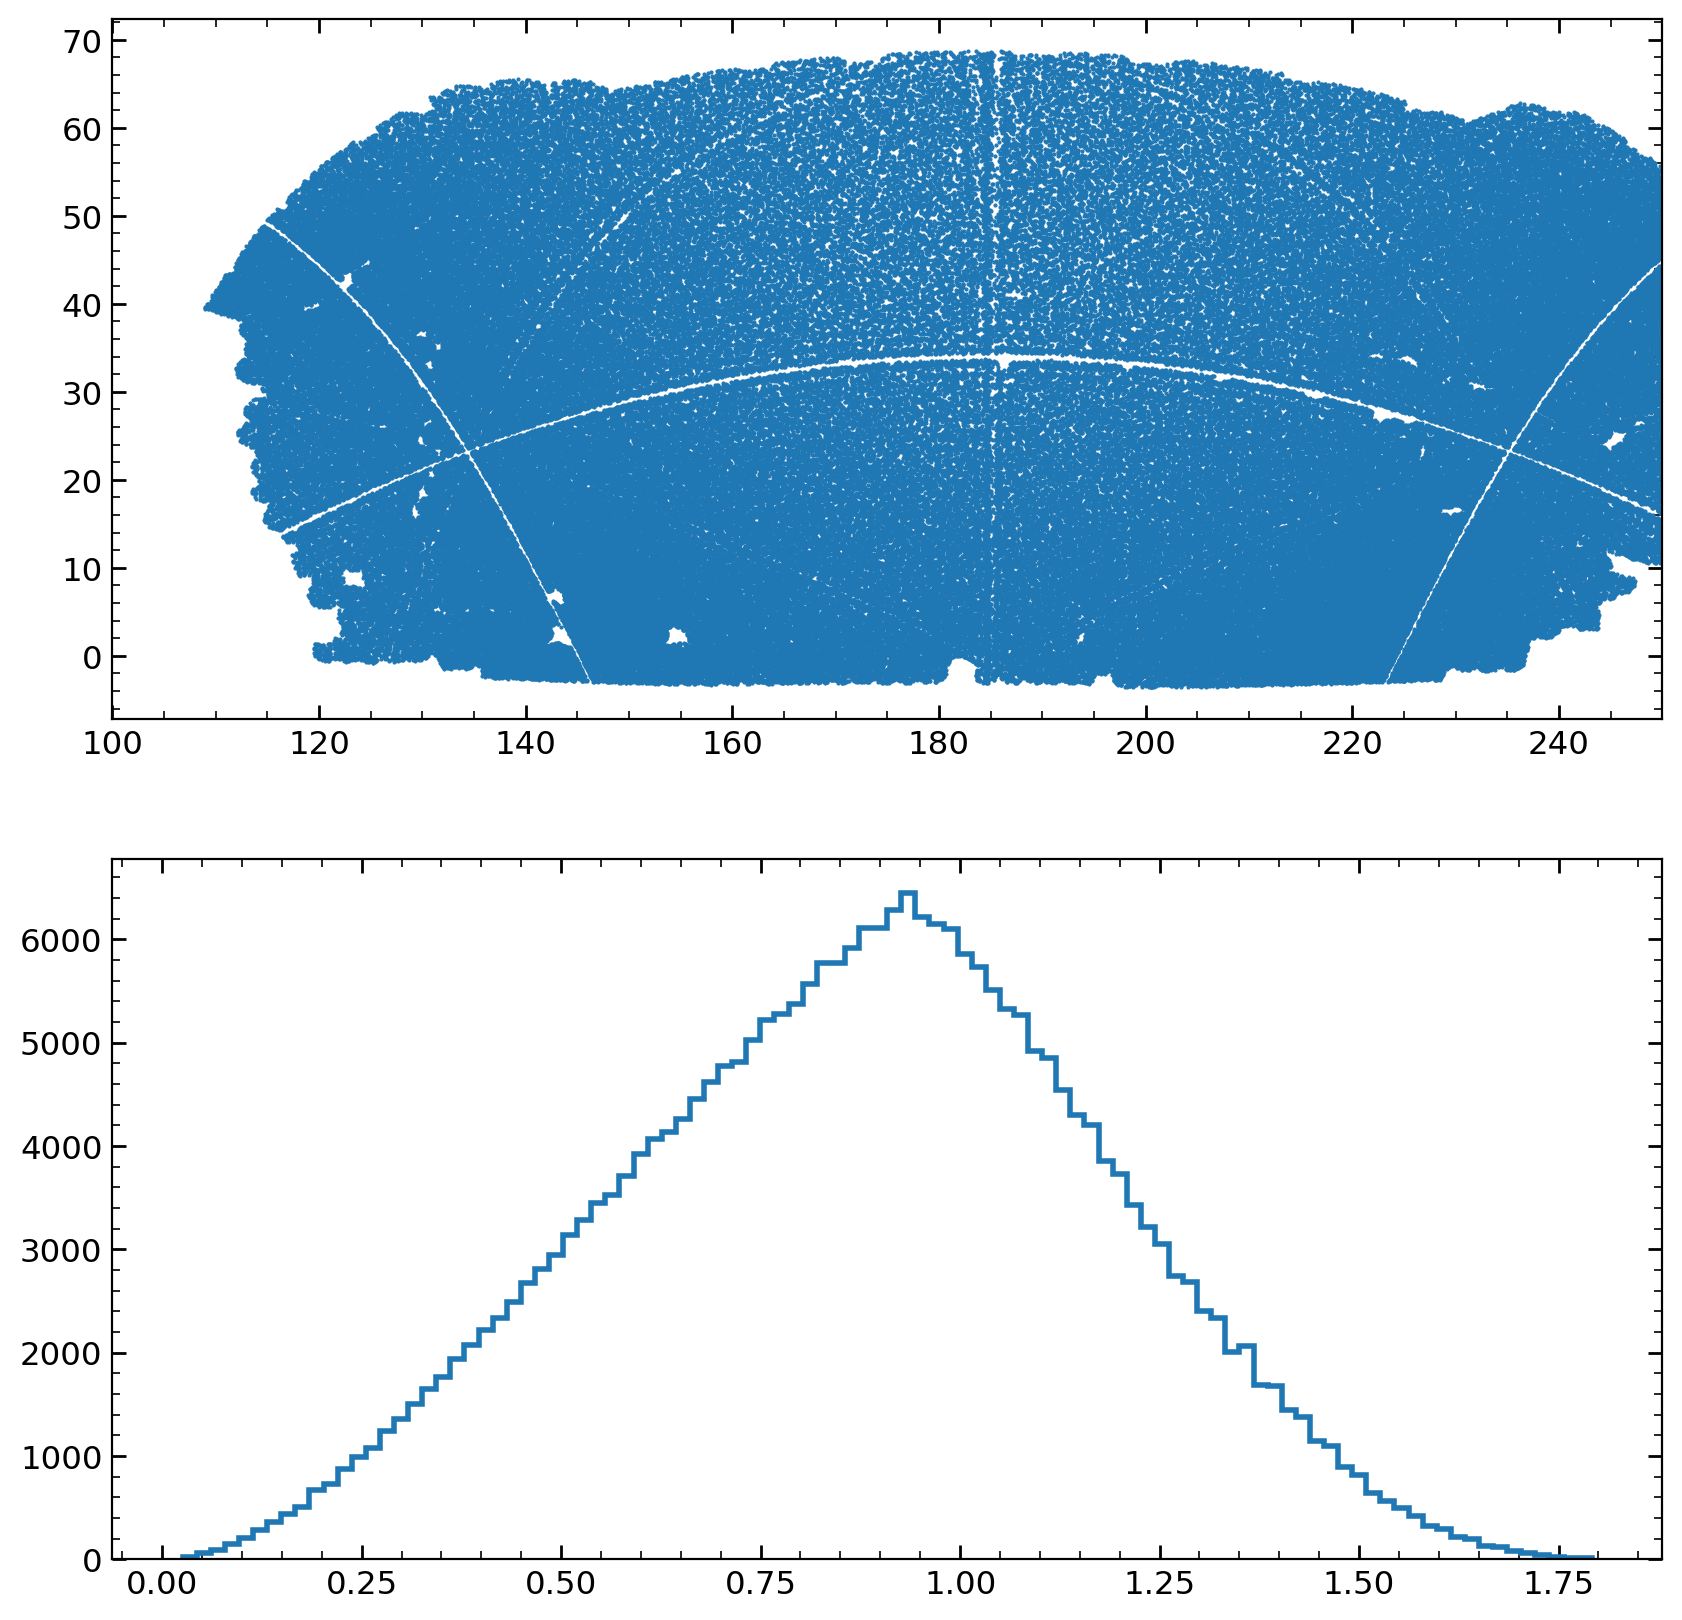

In [164]:
f, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(rdz[:, 0], rdz[:, 1], '.', ms=1, alpha=1)
axs[0].set_xlim(100,250)
axs[1].hist(rdz[:, 2], bins=100, histtype='step', lw=2);

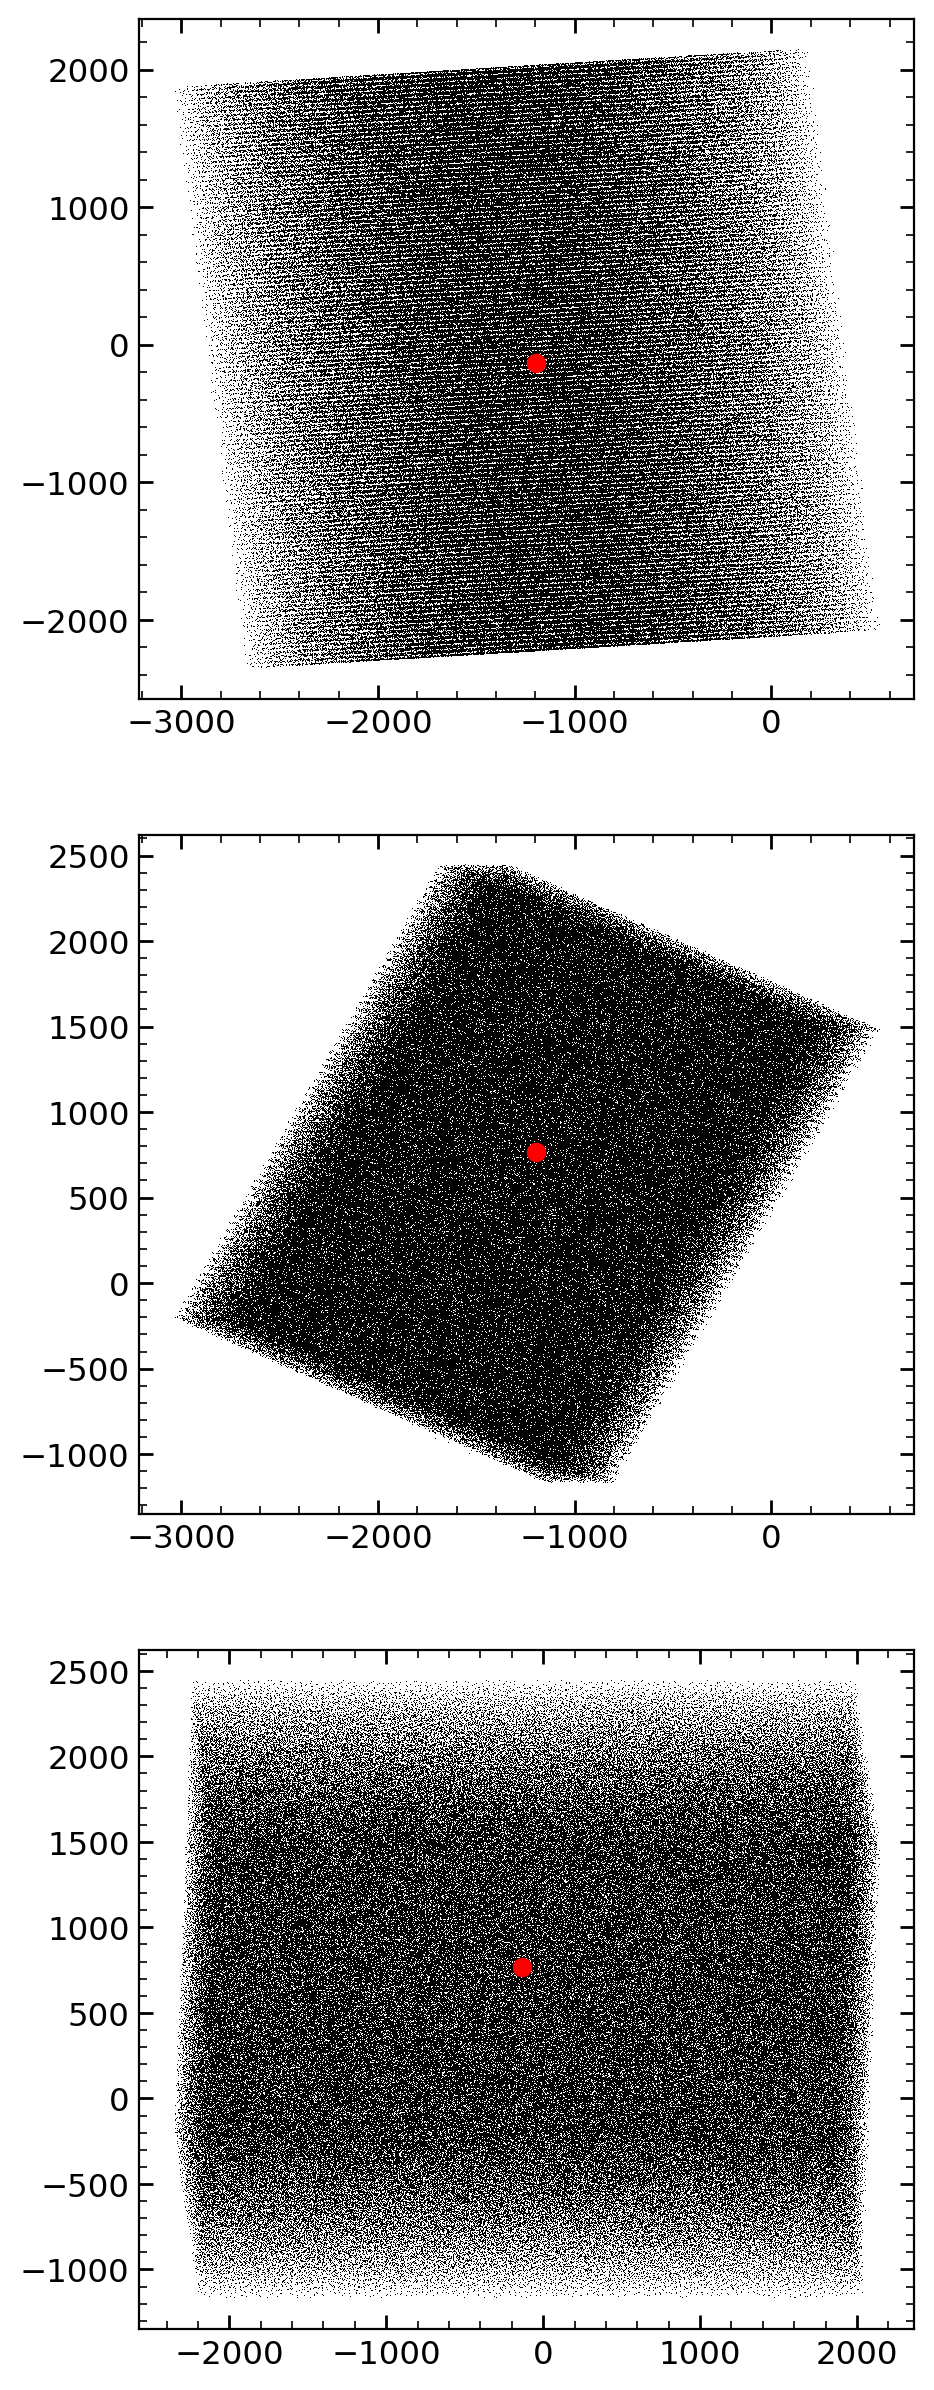

In [150]:
mid_xyz = sky_to_xyz([186.42231868123542, 32.55919031460393, 0.5500079542398453], cosmo)

f, axs = plt.subplots(3, 1, figsize=(5, 15))

ax = axs[0]
ax.plot(xyz[:, 0], xyz[:, 1], 'k,', alpha=1)
ax.plot(mid_xyz[0], mid_xyz[1], 'ro')

ax = axs[1]
ax.plot(xyz[:, 0], xyz[:, 2], 'k,', alpha=1)
ax.plot(mid_xyz[0], mid_xyz[2], 'ro')

ax = axs[2]
ax.plot(xyz[:, 1], xyz[:, 2], 'k,', alpha=1)
ax.plot(mid_xyz[1], mid_xyz[2], 'ro')
